In [1]:
srand(1234)
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [2]:
@everywhere include("newtrees.jl")
@everywhere using Trees

@everywhere using AccessMacro
@everywhere using Missings
@everywhere using LogProbs
@everywhere using DataStructures
@everywhere using DataFrames

@everywhere using StatsFuns.RFunctions: gammarand

@everywhere using LightGraphs: Graph, add_vertex!, add_edge!, nv

@everywhere import TikzGraphs: plot
@everywhere import Base: show, hash, ==
@everywhere import Base: +, -, *, /, zero, one, <
@everywhere import Base: start, length, insert!, isempty, convert, getindex, promote_rule, range
@everywhere import DataStructures: enqueue!, dequeue!

In [3]:
import Plots
import Distributions

# iReal pro parsing -- My ISMIR paper 2018

## Load parser, grammar, & data and plot first parse tree

In [4]:
@everywhere cd("/Users/daniel/Documents/GitHub/GeneralizedChartparsing")
@everywhere include("src/jazz_parser/newjazz.jl")

number_chord_symbols = size(vcat(iReal_songs[:chords]...)) = (59396, 8)
(terminals(iReal_songs[4, :chords]))[1:13] = JazzTerminal[C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^]
	From worker 2:	number_chord_symbols = size(vcat(iReal_songs[:chords]...)) = (59396, 8)
	From worker 5:	number_chord_symbols = size(vcat(iReal_songs[:chords]...)) = (59396, 8)


In [5]:
chords = terminals(iReal_songs[4, :chords])[1:13]
grammar = init_jazz_grammar()
@time forest = run_chartparser(chords, grammar);
sample_tree(forest)

	From worker 4:	number_chord_symbols = size(vcat(iReal_songs[:chords]...)) = (59396, 8)
	From worker 3:	number_chord_symbols = size(vcat(iReal_songs[:chords]...)) = (59396, 8)
	From worker 2:	(terminals(iReal_songs[4, :chords]))[1:13] = JazzTerminal[C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^]
	From worker 5:	(terminals(iReal_songs[4, :chords]))[1:13] = JazzTerminal[C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^]
	From worker 4:	(terminals(iReal_songs[4, :chords]))[1:13] = JazzTerminal[C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^]
	From worker 3:	(terminals(iReal_songs[4, :chords]))[1:13] = JazzTerminal[C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^, Am7, Dm7, G7, C^] 
 2.662845 seconds (4.37 M allocations: 189.675 MiB, 4.48% gc time)


[I_{a}[III_{a}[III_{a}[C^]][III_{a}[III_{a}[III_{a}[I_{C}[V_{C}[II_{C}[V_{d}[I_{a}[Am7]]][II_{C}[Dm7]]][V_{C}[G7]]][I_{C}[C^]]]][III_{a}[V_{C}[II_{C}[VI_{C}[Am7]][II_{C}[Dm7]]][V_{C}[G7]]][III_{a}[C^]]]][III_{a}[V_{C}[II_{C}[VI_{C}[Am7]][II_{C}[Dm7]]][V_{C}[G7]]][III_{a}[C^]]]]]]

In [6]:
"""
    unzip(iter)

unzip an iterable object of indexable objects
"""
function unzip(iter)
    ntuple(length(first(iter))) do i
        map(iter) do indexable
            getindex(indexable, i)
        end
    end
end
        
# test
unzip([(1,2,3), (11,22,33)]) == ([1, 11], [2, 22], [3, 33])

true

In [7]:
function rules_df(grammar) 
    lst = [
        (replace(string(components), '_', ", "), count, string(rule))
        for components in keys(grammar.cond.dists)
        for (rule, count) in grammar.cond.dists[components].counts
    ]
    
    df = DataFrame(collect(unzip(lst)), [:components, :count, :rule])
    sort(df, cols=[order(:components), order(:count, rev=true)])
end

rules_df (generic function with 1 method)

In [8]:
DataFrames.head(rules_df(grammar))

,components,count,rule
1,"(I, ""major"")",1.0,CFRule(diatonic_subs)
2,"(I, ""major"")",1.0,CFRule(prolongation)
3,"(I, ""major"")",1.0,CFRule(mode_change)
4,"(I, ""major"")",1.0,CFRule(diatonic_prep)
5,"(I, ""major"")",1.0,CFRule(plagal_prep)
6,"(I, ""major"")",0.3333333333333333,CFRule(^7_termination)


In [9]:
size(rules_df(init_jazz_grammar()), 1), size(rules_df(init_jazz_grammar(identity)), 1)

(107, 1284)

In [10]:
12*size(rules_df(init_jazz_grammar()), 1) == size(rules_df(init_jazz_grammar(identity)), 1)

true

## Prior Accuracies

In [11]:
meta_grammar_prior = init_jazz_grammar()
plain_grammar_prior = init_jazz_grammar(identity);

In [12]:
lines = readlines("/Users/daniel/Documents/GitHub/iRealPro/compiled_tree_data.txt")
gold_names  = lines[collect(1:3:length(lines))]
gold_leafss = eval.(parse.(lines[collect(2:3:length(lines))]))
gold_trees  = tree.(lines[collect(3:3:length(lines))]);

In [13]:
t = sample_tree(run_chartparser(gold_leafss[1], meta_grammar_prior))

[I_{a}[III_{a}[III_{a}[C^7]][III_{a}[III_{a}[C^7]][III_{a}[VII_{a}[V_{G}[II_{G}[II_{G}[I_{a}[IV_{a}[V_{d}[V_{a}[V_{a}[E7]][V_{a}[E7]]][V_{d}[A7]]][IV_{a}[V_{d}[A7]][IV_{a}[IV_{a}[Dm7]][IV_{a}[Dm7]]]]][I_{a}[V_{a}[E7]][I_{a}[V_{a}[E7]][I_{a}[I_{A}[I_{a}[Am7]]]]]]]][II_{G}[Am7]]][V_{G}[V_{G}[D7]][V_{G}[D7]]]][VII_{a}[IV_{a}[Dm7]][VII_{a}[G7]]]][III_{a}[III_{a}[III_{a}[I_{C}[C^7]]][III_{a}[C^7]]][III_{a}[V_{C}[II_{C}[V_{d}[V_{a}[V_{f#}[VII_{f#}[VII_{f#}[E7]][VII_{f#}[E7]]]]][V_{d}[V_{f}[V_{b}[V_{d}[A7]]]]]][II_{C}[II_{C}[II_{C}[V_{d}[A7]][II_{C}[I_{d}[Dm7]]]][II_{C}[Dm7]]][II_{C}[IV_{C}[F^7]]]]][V_{C}[V_{Eb}[Fm6]]]][III_{a}[VII_{a}[VII_{a}[I_{G}[VI_{G}[Em7]]]][VII_{a}[IV_{a}[V_{d}[A7]][IV_{a}[Dm7]]][VII_{a}[G7]]]][III_{a}[C6]]]]]]]]]

In [14]:
@everywhere function boolean_dependency_matrix(t::Tree)
    map(x-> x == "" ? false : true, dependency_matrix(t))
end

@everywhere function dependency_matrix(t::Tree)
    t = map(x->"x", t)
    k = add_leaf_indices!(t)
    add_inner_dependency_indices!(t)

    M = ["" for i in 1:k, j in 1:k]
    for node in t
        m = match(r"(.+) (\d+) (\d+)", node.data)
        M[parse(m[2]), parse(m[3])] = m[1]
    end
    M
end

@everywhere function add_leaf_indices!(tree::Tree)
    k = 1
    for node in tree
        if isleaf(node)
            node.data *= " $k $(k+1)"
            k += 1
        end
    end
    k # highest indices
end

@everywhere function add_inner_dependency_indices!(treenode::Tree)
    if !isleaf(treenode)
        m1 = match(r" (\d+) (\d+)", add_inner_dependency_indices!(treenode.children[1]).data)
        m2 = match(r" (\d+) (\d+)", add_inner_dependency_indices!(treenode.children[end]).data)
        treenode.data *= " $(m1[1]) $(m2[2])"
    end
    treenode
end

@everywhere Base.precision(proposal, goldstandard) =
    num_common_cons(proposal, goldstandard) / num_cons(proposal)
@everywhere recall(proposal, goldstandard) =
    num_common_cons(proposal, goldstandard) / num_cons(goldstandard)
@everywhere f1_measure(proposal, goldstandard) =
    2 * precision(proposal, goldstandard) * recall(proposal, goldstandard) /
       (precision(proposal, goldstandard) + recall(proposal, goldstandard))

@everywhere function num_cons(tree::Tree)
    M = boolean_dependency_matrix(tree)
    count(M) - size(M, 1)
end

@everywhere function num_common_cons(tree1::Tree, tree2::Tree)
    A = boolean_dependency_matrix(tree1)
    B = boolean_dependency_matrix(tree2)
    sum(a && b for (a,b) in zip(A,B)) - size(A, 1)
end

In [15]:
@time meta_prior_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, meta_grammar_prior))), t)
end

 28.562779 seconds (1.96 M allocations: 88.904 MiB, 0.34% gc time)


13-element Array{Float64,1}:
 0.0689655
 0.615385 
 0.230769 
 0.290323 
 0.230769 
 0.431034 
 0.533333 
 0.309091 
 0.353846 
 0.444444 
 0.387755 
 0.490566 
 0.333333 

In [16]:
mean(meta_prior_accs)

0.36304730549177516

In [17]:
@time plain_prior_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, plain_grammar_prior))), t)
end

 24.375478 seconds (774.32 k allocations: 21.996 MiB, 0.06% gc time)


13-element Array{Float64,1}:
 0.0689655
 0.615385 
 0.230769 
 0.290323 
 0.230769 
 0.431034 
 0.533333 
 0.309091 
 0.353846 
 0.444444 
 0.387755 
 0.490566 
 0.333333 

In [18]:
mean(plain_prior_accs)

0.36304730549177516

## Inference

In [19]:
@everywhere using Counters

@everywhere function approx_expected_rule_usage(forest, grammar; number_samples=20*length(terminals(forest)))
    if iscomplete(forest)
        rule_usage_by_tree = map([sample_tree(forest).rules for _ in 1:number_samples]) do rules
            rule_counts = Counters.counter(
                map(rules) do category_and_rule
                    c, r = category_and_rule
                    dependent_components(grammar, c), r
                end
            )
            # Dict(r => log(c) for (r, c) in rule_counts)
        end

        Dict(
            k => v / number_samples
            for (k, v) in merge(+, rule_usage_by_tree...)
        )
    else
        Dict()
    end
end

batches(ss, batch_size) = [
    ss[(k * batch_size + 1):(k * batch_size + batch_size)]
    for k in 0:div(length(ss), batch_size)-1
]

# forgetting rate ∈ (0.5,1], delay ≧ 0
step_size(i; delay=100, forgetting_rate=1.0) = (i + delay)^(-forgetting_rate)

*(d::Dict, λ::Number) = Dict(k => λ*v for (k, v) in d)

* (generic function with 260 methods)

In [20]:
function do_inference!(
        grammar = init_jazz_grammar(),
        accs = Float64[],
        outer_loop = 2,
        batch_size = 8,
        minimal_sequence_length = 1,
        maximal_sequence_length = 40,
    )
    
    grammar_type = grammar.dependent_components == identity ? "plain" : "meta"
    
    # get the data
    sequence_lengths = size.(iReal_songs[:chords], 1)
    sequences = sort(
        terminals.(
            iReal_songs[
                find(sequence_lengths) do n
                    minimal_sequence_length <= n <= maximal_sequence_length
                end, 
                :chords
            ]
        ),
        by=length
    )
    @show length(sequences)
    
    # initialize output table
    rules_data = rules_df(grammar)
    rules_data[:step] = -1
    DataFrames.head(rules_data)

    # parsable = SharedVector{Bool}(length(sequences))
    # 
    # # create and observe initial parse trees
    # @time for (i, batch) in enumerate(batches(sequences, batch_size))
    #     print("$i/$(div(length(sequences), batch_size))\t$(length.(batch))\t")
    #     @time initial_parse_trees = pmap(enumerate(batch)) do index_and_sequence
    #         k, s = index_and_sequence
    #         forest = run_chartparser(s, init_jazz_grammar(), cyclic=true)
    #         parsable[(i-1)*batch_size + k] = iscomplete(forest)
    #         iscomplete(forest) ? sample_tree(forest) : missing
    #     end
    # 
    #     for t in initial_parse_trees[.!ismissing.(initial_parse_trees)]
    #         for (c, r) in t.rules
    #             grammar.cond.dists[dependent_components(grammar, c)].counts[r] += 1
    #         end
    #     end
    # end

    # # compile parsable sequences
    # ss = sequences[parsable]
    # L = length(sequences)
    # N = length(ss)
    # println((L-mod(L, batch_size), N, N / (L-mod(L, batch_size))))
    # println()
    
    ss = sequences
    L = length(sequences)
    N = length(ss)
    accs = Float64[]
    
    df = rules_df(grammar)
    df[:step] = 0
    rules_data = vcat(rules_data, df)
    
    m = mean(pmap(gold_leafss, gold_trees) do ls, t
        precision(convert(Tree, best_tree(run_chartparser(ls, grammar))), t)
    end)
    println("mean tree accuracy: $m")
    println()
    push!(accs, m)
    
    @time for j in 0:outer_loop-1
        println("outer loop $(j+1)")
        @time for (i, batch) in enumerate(shuffle(batches(ss, batch_size)))
            step = j * div(N, batch_size) + i
            α    = step_size(step)
            print("$i/$(div(N, batch_size)) ")

            rule_usage_by_sequence = pmap(shuffle(batch)) do s
                approx_expected_rule_usage(run_chartparser(s, grammar, cyclic=true), grammar)
            end

            total_rule_usage = merge(+, rule_usage_by_sequence...) * (N/batch_size)

            for c in keys(grammar.cond.dists)
                for r in keys(grammar.cond.dists[c].counts)
                    grammar.cond.dists[c].counts[r] = 
                        (1-α) * grammar.cond.dists[c].counts[r] + 
                           α  * (haskey(total_rule_usage, (c, r)) ? total_rule_usage[c, r] : 0.0)
                end
            end
            
            m = mean(pmap(gold_leafss, gold_trees) do ls, t
                precision(convert(Tree, best_tree(run_chartparser(ls, grammar))), t)
            end)
            println("mean tree accuracy: $m")
            println()
            push!(accs, m)

            df = rules_df(grammar)
            df[:step] = step
            rules_data = vcat(rules_data, df)
            
            writetable(
                "src/jazz_parser/rules_data_min$(minimal_sequence_length)_max$(maximal_sequence_length)_$(grammar_type).tsv", 
                rules_data
            )
        end

        # m = mean(pmap(gold_leafss, gold_trees) do ls, t
        #     precision(convert(Tree, best_tree(run_chartparser(ls, grammar))), t)
        # end)
        # println("mean tree accuracy: $m")
        # println()
    end
    grammar, accs, rules_data
end

do_inference! (generic function with 7 methods)

In [21]:
meta_grammar, meta_accs, meta_rules_data = do_inference!(init_jazz_grammar());

length(sequences) = 394
mean tree accuracy: 0.36304730549177516

outer loop 1
1/49 mean tree accuracy: 0.41469755712501755

2/49 mean tree accuracy: 0.4096353232834503

3/49 mean tree accuracy: 0.43017643451690585

4/49 mean tree accuracy: 0.43668182080405266

5/49 mean tree accuracy: 0.42154140455002087

6/49 mean tree accuracy: 0.46853460900210836

7/49 mean tree accuracy: 0.44422499634636653

8/49 mean tree accuracy: 0.4362086129613899

9/49 mean tree accuracy: 0.45770132632444466

10/49 mean tree accuracy: 0.42665325351813005

11/49 mean tree accuracy: 0.4564422679225291

12/49 mean tree accuracy: 0.44831369533869175

13/49 mean tree accuracy: 0.46734564358686315

14/49 mean tree accuracy: 0.47691865401278055

15/49 mean tree accuracy: 0.44154109233773625

16/49 mean tree accuracy: 0.41534122011811997

17/49 mean tree accuracy: 0.46262882788318116

18/49 mean tree accuracy: 0.47166342011277645

19/49 mean tree accuracy: 0.4399439068087187

20/49 mean tree accuracy: 0.45761790377013

In [22]:
plain_grammar, plain_accs, plain_rules_data = do_inference!(init_jazz_grammar(identity));

length(sequences) = 394
mean tree accuracy: 0.36304730549177516

outer loop 1
1/49 mean tree accuracy: 0.3361349219509979

2/49 mean tree accuracy: 0.36478611193014987

3/49 mean tree accuracy: 0.3543904085444701

4/49 mean tree accuracy: 0.40753401676856144

5/49 mean tree accuracy: 0.4325013640287806

6/49 mean tree accuracy: 0.4219256053503889

7/49 mean tree accuracy: 0.39852751433371686

8/49 mean tree accuracy: 0.3920453623037552

9/49 mean tree accuracy: 0.40182658146352684

10/49 mean tree accuracy: 0.42024303008116665

11/49 mean tree accuracy: 0.3956735937834456

12/49 mean tree accuracy: 0.4122003780832318

13/49 mean tree accuracy: 0.3815137385253189

14/49 mean tree accuracy: 0.41618028192424794

15/49 mean tree accuracy: 0.37081779500082646

16/49 mean tree accuracy: 0.39271186060279706

17/49 mean tree accuracy: 0.3782550719701843

18/49 mean tree accuracy: 0.3856018513328788

19/49 mean tree accuracy: 0.37677504220261315

20/49 mean tree accuracy: 0.38947152969975807

2

In [55]:
p = Plots.plot([meta_accs, plain_accs], labels=["PACFG","PCFG"], xlabel="minibatch update", ylabel="accuracy")
Plots.savefig(p, "minibatchupdates.png")
p

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0.36 
 
 
 0.39 
 
 
 0.42 
 
 
 0.45 
 
 
 0.48 
 
 
 minibatch update 
 
 
 accuracy 
 
<polyline clip-path="url(#clip2502)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 54.9131,303.447 60.2744,194.679 65.6356,205.339 70.9968,162.083 76.3581,148.383 81.7193,180.267 87.0806,81.3057 92.4418,132.498 97.8031,149.38 103.164,104.119 
 108.526,169.502 113.887,106.77 119.248,123.888 124.609,83.8095 129.971,63.6501 135.332,138.15 140.693,193.323 146.054,93.7424 151.415,74.7168 156.777,141.514 
 162.138,104.295 167.499,118.845 172.86,140.281 178.222,44.395 183.583,31.9343 188.944,85.8779 194.305,118.251 199.667,147.275 205.028,134.285 210.389,139.532 
 215.75,95.868 221.112,118.526 226.473,108.329 231.834,102.743 237.195,107.727 242.557,119.735 247.918,105.235 253.279,99.999 258.64,118.124 264.002,88.4218 
 269.363,72.0173 274.724,96.2048 280.085,82.6068 285.447,43.5276 290.808,11.811 296.169,95.9201 301.53,93.3771 306.892,71.2504 312.253,52.4268 317.614,97.9335 
 322.975,64.3441 328.337,64.8875 333.698,61.5816 339.059,57.7911 344.42,38.9093 349.781,74.764 355.143,117.504 360.504,40.5624 365.865,95.4878 371.226,96.8723 
 376.588,51.6564 381.949,46.219 387.31,17.5996 392.671,17.5996 398.033,118.418 403.394,118.418 408.755,91.6841 414.116,94.686 419.478,105.957 424.839,124.458 
 430.2,130.214 435.561,110.262 440.923,108.011 446.284,110.262 451.645,72.7857 457.006,60.325 462.368,67.8014 467.729,66.9468 473.09,63.3471 478.451,72.4849 
 483.813,58.6606 489.174,74.3541 494.535,74.3541 499.896,76.999 505.258,91.5089 510.619,93.6506 515.98,96.707 521.341,86.7384 526.703,118.115 532.064,77.0387 
 537.425,137.904 542.786,126.255 548.148,126.054 553.509,131.184 558.87,92.3454 564.231,169 569.592,69.411 574.954,87.721 580.315,87.721 
 "/>
<polyline clip-path="url(#clip2502)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 54.9131,303.447 60.2744,360.121 65.6356,299.785 70.9968,321.677 76.3581,209.764 81.7193,157.187 87.0806,179.458 92.4418,228.731 97.8031,242.381 103.164,221.783 
 108.526,183.001 113.887,234.741 119.248,199.938 124.609,264.559 129.971,191.556 135.332,287.083 140.693,240.978 146.054,271.422 151.415,255.95 156.777,274.538 
 162.138,247.801 167.499,201.156 172.86,246.297 178.222,256.502 183.583,248.021 188.944,207.949 194.305,206.885 199.667,209.925 205.028,200.493 210.389,185.066 
 215.75,249.983 221.112,247.261 226.473,276.793 231.834,241.571 237.195,241.028 242.557,262.781 247.918,204.299 253.279,279.619 258.64,221.49 264.002,157.451 
 269.363,205.931 274.724,240.087 280.085,235.07 285.447,194.678 290.808,191.635 296.169,194.428 301.53,183.972 306.892,215.919 312.253,225.163 317.614,272.877 
 322.975,233.755 328.337,182.904 333.698,226.409 339.059,207.227 344.42,219.063 349.781,227.167 355.143,193.267 360.504,206.425 365.865,213.029 371.226,241.808 
 376.588,214.976 381.949,180.01 387.31,278.3 392.671,276.943 398.033,269.542 403.394,281.876 408.755,239.301 414.116,284.174 419.478,286.029 424.839,263.168 
 430.2,281.308 435.561,261.439 440.923,231.864 446.284,231.888 451.645,199.486 457.006,276.442 462.368,265.643 467.729,195.082 473.09,235.841 478.451,216.083 
 483.813,221.881 489.174,249.785 494.535,271.592 499.896,250.441 505.258,238.265 510.619,252.251 515.98,256.85 521.341,254.477 526.703,200.813 532.064,249.084 
 537.425,220.772 542.786,244.86 548.148,253.604 553.509,256.562 558.87,242.597 564.231,237.45 569.592,268.97 574.954,295.741 580.315,259.049 
 "/>
 
 
 
 
 PACFG 
 
 
 
 PCFG

## Evaluation

In [24]:
lines = readlines("/Users/daniel/Documents/GitHub/iRealPro/compiled_tree_data.txt")
gold_names  = lines[collect(1:3:length(lines))]
gold_leafss = eval.(parse.(lines[collect(2:3:length(lines))]))
gold_trees  = tree.(lines[collect(3:3:length(lines))])
length(gold_trees)

13

In [25]:
gold_names

13-element Array{String,1}:
 "allofme"              
 "anthropology"         
 "berniestune"          
 "beyondthebluehorizon" 
 "bluebossa"            
 "bluemoon"             
 "bluesforalice"        
 "canthelplovindatman"  
 "dreamalittledreamofme"
 "flintstones"          
 "honeysucklerose"      
 "satindoll"            
 "sway"                 

In [26]:
@time prior_meta_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, meta_grammar_prior))), t)
end
mean(meta_prior_accs)

 23.013090 seconds (630.08 k allocations: 17.516 MiB)


0.36304730549177516

In [27]:
@time final_meta_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, meta_grammar))), t)
end
mean(meta_accs)

 24.055433 seconds (631.13 k allocations: 16.570 MiB)


0.4594900106362008

In [28]:
@time prior_plain_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, plain_grammar_prior))), t)
end
mean(plain_prior_accs)

 23.602191 seconds (755.46 k allocations: 20.989 MiB, 0.07% gc time)


0.36304730549177516

In [29]:
@time final_plain_accs = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, plain_grammar))), t)
end
mean(plain_accs)

 23.460136 seconds (755.58 k allocations: 20.913 MiB, 0.07% gc time)


0.3942998557978456

In [38]:
right_baseline_grammar = begin
    implication = CFRule(['S']) do c
        ['S', 'A']
    end
    stop = CFRule(['S']) do c
        ['A']
    end
    termination = CFRule(['A']) do c
        ['a']
    end
    CFGrammar([implication, stop], [termination], ['S'])
end

right_branching_baseline_accs = map(gold_trees, gold_leafss) do t, ls
    precision(convert(Tree, best_tree(run_chartparser(fill('a', length(ls)), right_baseline_grammar))), t)
end
mean(right_branching_baseline_accs)

0.08170094556657183

In [36]:
random_baseline_grammar = begin
    prolongation = CFRule(['A']) do c
        ['A', 'A']
    end
    termination = CFRule(['A']) do c
        ['a']
    end
    CFGrammar([prolongation], [termination], ['A'])
end

random_baseline_accs = vcat(collect(
    map(gold_trees, gold_leafss) do t, ls
        precision(convert(Tree, sample_tree(run_chartparser(fill('a', length(ls)), random_baseline_grammar))), t)
    end
    for _ in 1:12
)...)
mean(random_baseline_accs)

0.1535240955185842

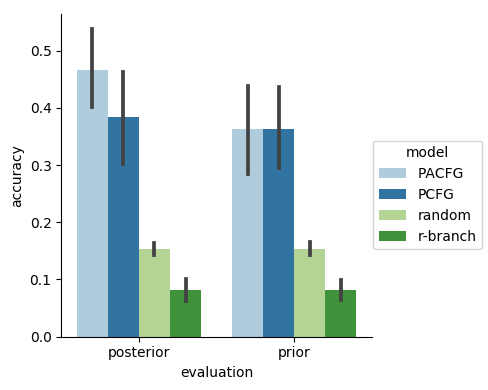

PyObject <seaborn.axisgrid.FacetGrid object at 0x1359f4cc0>

In [59]:
import DataFrames
import Seaborn
import Pandas
panda(df) = Pandas.DataFrame(Dict(n => df[n] for n in names(df)))

n = length(final_meta_accs)
df = vcat(
    DataFrame(accuracy=final_meta_accs, model=fill("PACFG", n), evaluation=fill("posterior", n)),
    DataFrame(accuracy=prior_meta_accs, model=fill("PACFG", n), evaluation=fill("prior", n)),
    DataFrame(accuracy=final_plain_accs, model=fill("PCFG", n), evaluation=fill("posterior", n)),
    DataFrame(accuracy=prior_plain_accs, model=fill("PCFG", n), evaluation=fill("prior", n)),
    DataFrame(accuracy=random_baseline_accs, model=fill("random", 12n), evaluation=fill("posterior", 12n)),
    DataFrame(accuracy=random_baseline_accs, model=fill("random", 12n), evaluation=fill("prior", 12n)),
    DataFrame(accuracy=right_branching_baseline_accs, model=fill("r-branch", n), evaluation=fill("posterior", n)),
    DataFrame(accuracy=right_branching_baseline_accs, model=fill("r-branch", n), evaluation=fill("prior", n)),
)
p = Seaborn.factorplot(data=panda(df), x=:evaluation, y=:accuracy, hue=:model, kind=:bar, palette=:Paired)
Seaborn.savefig("barplot.png", dpi=300)
p

In [32]:
mean(meta_accs), mean(plain_accs)

(0.4594900106362008, 0.3942998557978456)

## More Evaluations

In [41]:
sequence_lengths = size.(iReal_songs[:chords], 1)
sequences = sort(
    terminals.(
        iReal_songs[
            find(sequence_lengths) do n
                1 <= n <= 40
            end, 
            :chords
        ]
    ),
    by=length
)
length(sequences)

394

In [47]:
@time linear_parsable = pmap(sequences) do s
    iscomplete(run_chartparser(s, grammar))
end

272.254176 seconds (18.51 M allocations: 432.528 MiB, 0.11% gc time)


394-element DataArrays.DataArray{Bool,1}:
  true
 false
 false
 false
 false
 false
 false
 false
 false
  true
  true
 false
 false
     ⋮
 false
  true
 false
 false
  true
 false
  true
 false
 false
 false
 false
  true

In [118]:
mean(linear_parsable), sum(linear_parsable)

(0.34517766497461927, 136)

In [50]:
cyclic_parsable = 357

357

In [51]:
357 / 394

0.9060913705583756

## Diagnostics

In [93]:
DataFrames.head(meta_rules_data)

,components,count,rule,step
1,"(I, ""major"")",1.0,CFRule(diatonic_subs),-1
2,"(I, ""major"")",1.0,CFRule(prolongation),-1
3,"(I, ""major"")",1.0,CFRule(mode_change),-1
4,"(I, ""major"")",1.0,CFRule(diatonic_prep),-1
5,"(I, ""major"")",1.0,CFRule(plagal_prep),-1
6,"(I, ""major"")",0.3333333333333333,CFRule(^7_termination),-1


In [70]:
number_steps = maximum(meta_rules_data[:step])

98

In [71]:
all_rules = unique(collect(zip(meta_rules_data[:components], meta_rules_data[:rule])));

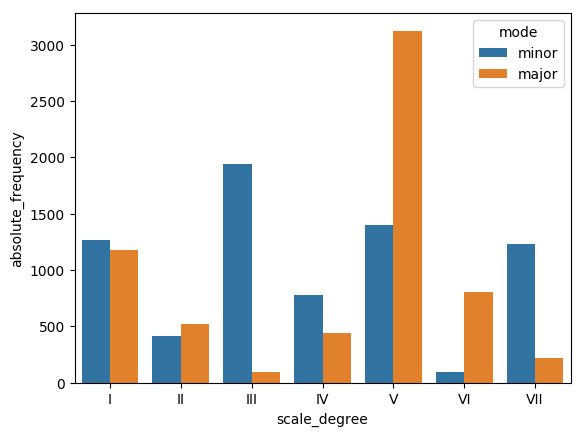

In [143]:
cs = by(meta_rules_data[meta_rules_data[:step] .== number_steps,:], :components) do df
    DataFrame(count=sum(df[:count]))
end
cs[:mode] = getindex.(match.(r"(major|minor)", cs[:components]), 1)
cs[:scale_degree] = getindex.(match.(r"(VII|VI|V|IV|III|II|I)", cs[:components]), 1)
cs[:absolute_frequency] = cs[:count]
Seaborn.reset_orig()
Seaborn.barplot(data=panda(cs), x=:scale_degree, y=:absolute_frequency, hue=:mode, hue_order=["minor","major"])
Seaborn.savefig("scaledegree frequencies.png", dpi=300)

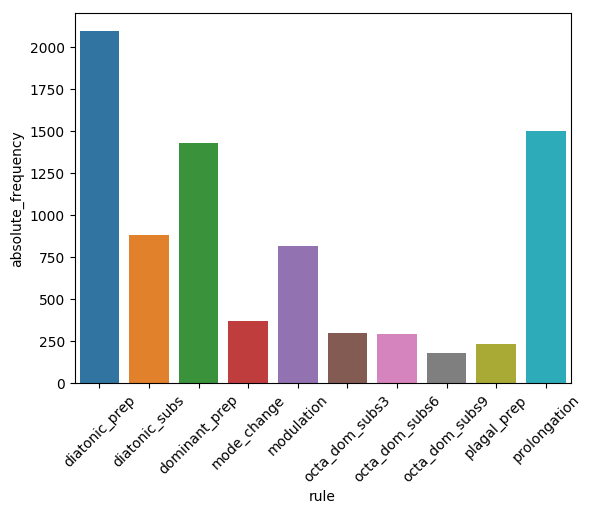

In [117]:
cs = by(meta_rules_data[meta_rules_data[:step] .== number_steps,:], :rule) do df
    DataFrame(count=sum(df[:count]))
end
cs = cs[find(r->!contains(r, "termination"), cs[:rule]), :]
cs[:rule] = getindex.(match.(r"\(([^)]+)\)", cs[:rule]), 1)
cs[:absolute_frequency] = cs[:count]
p = Seaborn.barplot(data=panda(cs), x=:rule, y=:absolute_frequency)
p[:set_xticklabels](cs[:rule], rotation=45)
Seaborn.savefig("rule frequencies.png", dpi=300)

## The change of the parameters

In [126]:
n_metarules = size(meta_rules_data[meta_rules_data[:step] .== -1, :], 1)

107

In [134]:
ps = aggregate(meta_rules_data, :step, collect)[:count_collect]
dists = map(ps[2:end], ps[1:end-1]) do p1, p2
    norm(p1-p2)
end
Plots.plot(dists)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
 
 40 
 
 
 50 
 
 
 60 
 
<polyline clip-path="url(#clip5902)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,375.869 34.7535,11.811 40.3779,94.3123 46.0022,228.462 51.6266,195.259 57.2509,248.886 62.8753,170.172 68.4996,75.807 74.124,147.56 79.7483,156.344 
 85.3726,269.79 90.997,224.295 96.6213,354.923 102.246,77.6557 107.87,139.412 113.494,127.352 119.119,290.466 124.743,228.101 130.367,109.782 135.992,179.813 
 141.616,154.734 147.24,91.7867 152.865,229.628 158.489,204.307 164.113,289.243 169.738,106.194 175.362,117.991 180.987,112.005 186.611,150.019 192.235,158.339 
 197.86,124.177 203.484,322.064 209.108,196.642 214.733,269.568 220.357,143.742 225.981,166.886 231.606,284.115 237.23,197.317 242.854,155.755 248.479,143.962 
 254.103,191.356 259.727,153.364 265.352,283.361 270.976,153.446 276.6,200.158 282.225,311.291 287.849,331.845 293.473,191.045 299.098,228.401 304.722,211.009 
 310.346,165.316 315.971,319.303 321.595,329.833 327.219,250.858 332.844,204.293 338.468,298.297 344.092,195.892 349.717,218.006 355.341,294.808 360.966,189.614 
 366.59,203.509 372.214,193.98 377.839,321.568 383.463,324.775 389.087,191.836 394.712,321.177 400.336,287.859 405.96,245.238 411.585,227.249 417.209,259.312 
 422.833,209.938 428.458,312.369 434.082,289.463 439.706,204.583 445.331,245.141 450.955,313.156 456.579,229.057 462.204,236.787 467.828,320.22 473.452,335.027 
 479.077,217.889 484.701,283.329 490.325,239.396 495.95,269.998 501.574,260.917 507.198,272.025 512.823,282.396 518.447,341.16 524.072,259.966 529.696,236.225 
 535.32,262.181 540.945,267.708 546.569,279.553 552.193,227.925 557.818,261.814 563.442,323.679 569.066,233.545 574.691,274.972 580.315,320.733 
 "/>
 
 
 
 
 y1

In [136]:
ps = aggregate(plain_rules_data, :step, collect)[:count_collect]
dists = map(ps[2:end], ps[1:end-1]) do p1, p2
    norm(p1-p2)
end
Plots.plot(dists)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 0 
 
 
 10 
 
 
 20 
 
 
 30 
 
<polyline clip-path="url(#clip6302)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,375.869 34.7535,109.723 40.3779,267.145 46.0022,73.0706 51.6266,236.835 57.2509,153.299 62.8753,348.092 68.4996,114.041 74.124,101.975 79.7483,245.717 
 85.3726,172.739 90.997,257.596 96.6213,91.575 102.246,200.461 107.87,122.55 113.494,128.152 119.119,115.426 124.743,301.308 130.367,90.4511 135.992,126.073 
 141.616,11.811 147.24,277.801 152.865,57.1099 158.489,227.622 164.113,138.736 169.738,110.22 175.362,264.652 180.987,116.059 186.611,154.274 192.235,164.752 
 197.86,266.857 203.484,197.238 209.108,145.899 214.733,78.8116 220.357,263.797 225.981,141.219 231.606,148.193 237.23,187.818 242.854,135.985 248.479,127.023 
 254.103,147.737 259.727,165.746 265.352,180.348 270.976,280.413 276.6,277.47 282.225,331.961 287.849,275.844 293.473,159.327 299.098,175.897 304.722,288.695 
 310.346,178.066 315.971,166.666 321.595,281.719 327.219,306.27 332.844,280.724 338.468,160.596 344.092,288.224 349.717,287.514 355.341,214.191 360.966,260.51 
 366.59,220.06 372.214,175.431 377.839,182.025 383.463,205.693 389.087,219.769 394.712,197.256 400.336,217.893 405.96,296.183 411.585,318.654 417.209,199.621 
 422.833,296.056 428.458,123.484 434.082,199.776 439.706,234.48 445.331,302.342 450.955,224.036 456.579,225.641 462.204,143.942 467.828,297.566 473.452,218.456 
 479.077,332.445 484.701,187.267 490.325,301.434 495.95,220.578 501.574,219.64 507.198,210.277 512.823,215.709 518.447,245.253 524.072,225.059 529.696,303.929 
 535.32,212.953 540.945,271.15 546.569,173.938 552.193,224.438 557.818,327.549 563.442,235.178 569.066,217.039 574.691,319.559 580.315,252.029 
 "/>
 
 
 
 
 y1

In [138]:
maximum(meta_rules_data[:step])/2

49.0

In [67]:
function get_counts_by_time(components, rule)
    meta_rules_data[
        (meta_rules_data[:components] .== components) .& 
        (meta_rules_data[:rule] .== rule) .&
        (meta_rules_data[:step] .>= 0), 
        :count
    ]
end

for components in unique(first.(all_rules))[1:14]
    let components_and_rules = filter(c->c[1]==components, all_rules)
        display(
            Plots.plot(
                [get_counts_by_time(c_and_r...) for c_and_r in components_and_rules], 
                labels = getindex.(components_and_rules, 2), 
                title  = string(components), 
                legend = :topleft
            )
        )
    end
end

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 250 
 
 
 (I, "major") 
 
<polyline clip-path="url(#clip2702)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,374.957 41.3759,368.306 46.9319,364.072 52.488,358.492 58.0441,355.354 63.6002,350.408 69.1562,345.729 74.7123,340.325 80.2684,333.914 85.8244,329.233 
 91.3805,325.047 96.9366,321.472 102.493,320.941 108.049,316.853 113.605,310.96 119.161,307.456 124.717,303.678 130.273,300.396 135.829,297.81 141.385,290.125 
 146.941,288.702 152.497,285.645 158.053,282.366 163.609,277.404 169.166,274.48 174.722,271.626 180.278,269.74 185.834,262.727 191.39,260.248 196.946,258.268 
 202.502,256.109 208.058,255.194 213.614,248.12 219.17,246.147 224.726,242.826 230.282,239.34 235.838,236.513 241.394,231.969 246.951,228.966 252.507,227.771 
 258.063,225.675 263.619,220.98 269.175,217.471 274.731,217.022 280.287,215.664 285.843,213.964 291.399,214.418 296.955,212.962 302.511,210.677 308.067,209.484 
 313.623,204.254 319.18,202.262 324.736,202.672 330.292,199.574 335.848,196.937 341.404,196.706 346.96,194.561 352.516,193.426 358.072,192.324 363.628,191.347 
 369.184,190.027 374.74,186.387 380.296,184.471 385.852,182.985 391.408,181.752 396.965,180.295 402.521,178.706 408.077,173.727 413.633,171.448 419.189,166.396 
 424.745,165.894 430.301,163.252 435.857,161.769 441.413,161.587 446.969,161.032 452.525,159.939 458.081,159.369 463.637,158.412 469.193,156.445 474.75,155.519 
 480.306,154.535 485.862,153.17 491.418,152.67 496.974,150.075 502.53,146.759 508.086,145.635 513.642,142.581 519.198,140.571 524.754,140.184 530.31,138.749 
 535.866,137.46 541.422,136.516 546.979,136.71 552.535,135.221 558.091,134.319 563.647,134.345 569.203,134.357 574.759,131.864 580.315,132.745 
 "/>
<polyline clip-path="url(#clip2702)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,374.957 41.3759,369.843 46.9319,361.283 52.488,358.52 58.0441,354.97 63.6002,354.339 69.1562,351.024 74.7123,346.27 80.2684,344.799 85.8244,340.511 
 91.3805,338.991 96.9366,338.922 102.493,339.219 108.049,336.272 113.605,332.942 119.161,330.935 124.717,329.709 130.273,328.88 135.829,323.808 141.385,319.124 
 146.941,317.323 152.497,317.329 158.053,313.091 163.609,309.343 169.166,306.717 174.722,306.463 180.278,305.724 185.834,302.45 191.39,302.148 196.946,301.068 
 202.502,299.105 208.058,299.534 213.614,293.194 219.17,292.932 224.726,291.915 230.282,288.332 235.838,287.593 241.394,283.952 246.951,282.699 252.507,282.373 
 258.063,281.778 263.619,281.324 269.175,279.338 274.731,277.978 280.287,274.821 285.843,274.428 291.399,275.093 296.955,274.686 302.511,270.087 308.067,270.138 
 313.623,267.554 319.18,267.257 324.736,267.914 330.292,264.416 335.848,261.517 341.404,260.316 346.96,259.339 352.516,259.016 358.072,259.014 363.628,257.783 
 369.184,256.381 374.74,255.801 380.296,255.14 385.852,254.906 391.408,255.36 396.965,255.765 402.521,253.989 408.077,249.614 413.633,247.484 419.189,244.501 
 424.745,244.485 430.301,243.459 435.857,243.932 441.413,243.534 446.969,241.462 452.525,241.319 458.081,241.414 463.637,241.265 469.193,240.778 474.75,239.192 
 480.306,239.592 485.862,238.691 491.418,236.185 496.974,234.564 502.53,233.616 508.086,230.144 513.642,227.656 519.198,227.53 524.754,227.907 530.31,227.554 
 535.866,227.633 541.422,227.256 546.979,226.507 552.535,224.796 558.091,220.025 563.647,220.725 569.203,220.698 574.759,218.548 580.315,219.337 
 "/>
<polyline clip-path="url(#clip2702)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,374.957 41.3759,366.614 46.9319,359.985 52.488,354.598 58.0441,349.694 63.6002,347.632 69.1562,343.682 74.7123,334.981 80.2684,331.685 85.8244,324.591 
 91.3805,322.885 96.9366,321.051 102.493,321.503 108.049,317.603 113.605,312.362 119.161,308.631 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 250 
 
 
 300 
 
 
 350 
 
 
 (I, "minor") 
 
<polyline clip-path="url(#clip2902)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.272 41.3759,364.026 46.9319,354.396 52.488,350.5 58.0441,343.374 63.6002,342.557 69.1562,335.993 74.7123,326.201 80.2684,321.994 85.8244,314.776 
 91.3805,312.997 96.9366,312.25 102.493,312.458 108.049,303.829 113.605,297.987 119.161,291.38 124.717,290.207 130.273,286.403 135.829,278.035 141.385,270.182 
 146.941,265.188 152.497,260.29 158.053,254.738 163.609,249.637 169.166,246.19 174.722,241.681 180.278,235.436 185.834,229.706 191.39,226.333 196.946,221.649 
 202.502,214.791 208.058,215.814 213.614,213.572 219.17,212.222 224.726,207.267 230.282,199.747 235.838,196.836 241.394,192.611 246.951,185.323 252.507,178.776 
 258.063,173.437 263.619,168.755 269.175,164.75 274.731,158.781 280.287,154.267 285.843,152.738 291.399,153.986 296.955,148.716 302.511,146.36 308.067,142.835 
 313.623,138.521 319.18,138.637 324.736,139.947 330.292,136.248 335.848,129.573 341.404,126.411 346.96,121.201 352.516,117.911 358.072,116.035 363.628,111.181 
 369.184,106.769 374.74,103.142 380.296,102.793 385.852,101.851 391.408,99.2842 396.965,100.347 402.521,96.8566 408.077,95.8832 413.633,91.841 419.189,87.9848 
 424.745,84.3478 430.301,81.2758 435.857,82.3351 441.413,78.6126 446.969,75.4425 452.525,75.0882 458.081,73.9028 463.637,69.8979 469.193,68.4346 474.75,67.0554 
 480.306,64.8812 485.862,63.2471 491.418,59.3744 496.974,57.6508 502.53,57.3793 508.086,56.0524 513.642,53.7429 519.198,54.2026 524.754,51.7913 530.31,49.0414 
 535.866,45.7687 541.422,43.1876 546.979,41.6577 552.535,37.9305 558.091,35.9554 563.647,37.5644 569.203,33.8631 574.759,31.4961 580.315,33.0664 
 "/>
<polyline clip-path="url(#clip2902)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.272 41.3759,372.1 46.9319,369.559 52.488,367.704 58.0441,365.855 63.6002,365.589 69.1562,363.287 74.7123,361.853 80.2684,357.921 85.8244,355.1 
 91.3805,353.974 96.9366,353.569 102.493,353.695 108.049,351.949 113.605,349.69 119.161,347.613 124.717,347.248 130.273,346.632 135.829,345.069 141.385,343.216 
 146.941,342.385 152.497,341.129 158.053,339.616 163.609,338.079 169.166,337.076 174.722,336.556 180.278,335.205 185.834,332.707 191.39,332.33 196.946,331.53 
 202.502,329.927 208.058,329.944 213.614,329.301 219.17,329.517 224.726,328.111 230.282,326.797 235.838,326.461 241.394,324.641 246.951,324 252.507,323.036 
 258.063,322.784 263.619,321.471 269.175,320.61 274.731,319.108 280.287,318.115 285.843,317.799 291.399,318.172 296.955,317.702 302.511,316.077 308.067,316.156 
 313.623,313.965 319.18,313.526 324.736,313.915 330.292,312.364 335.848,311.472 341.404,310.84 346.96,310.491 352.516,310.157 358.072,309.911 363.628,308.995 
 369.184,308.343 374.74,307.419 380.296,307.034 385.852,306.812 391.408,306.161 396.965,306.337 402.521,305.976 408.077,305.653 413.633,305.313 419.189,304.572 
 424.745,303.837 430.301,303.301 435.857,303.381 441.413,302.694 446.969,302.008 452.525,302.339 458.081,302.166 463.637,301.913 469.193,302.003 474.75,301.58 
 480.306,301.459 485.862,300.781 491.418,300.205 496.974,299.507 502.53,297.739 508.086,296.818 513.642,296.414 519.198,296.451 524.754,296.661 530.31,295.915 
 535.866,295.908 541.422,295.134 546.979,294.934 552.535,294.131 558.091,293.725 563.647,293.94 569.203,293.486 574.759,292.536 580.315,292.904 
 "/>
<polyline clip-path="url(#clip2902)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.272 41.3759,370.056 46.9319,367.785 52.488,365.11 58.0441,363.041 63.6002,361.929 69.1562,359.378 74.7123,356.717 80.2684,355.186 85.8244,350.9 
 91.3805,350.109 96.9366,349.242 102.493,349.19 108.049,345.744 113.605,344.4

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 (II, "major") 
 
<polyline clip-path="url(#clip3102)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.178 41.3759,372.267 46.9319,369.646 52.488,369.329 58.0441,367.467 63.6002,366.866 69.1562,365.979 74.7123,362.998 80.2684,362.175 85.8244,358.943 
 91.3805,357.22 96.9366,357.107 102.493,357.28 108.049,355.475 113.605,353.986 119.161,351.124 124.717,350.999 130.273,350.965 135.829,349.712 141.385,347.819 
 146.941,344.868 152.497,344.468 158.053,342.746 163.609,341.795 169.166,341.456 174.722,339.778 180.278,338.222 185.834,336.424 191.39,334.532 196.946,333.234 
 202.502,331.687 208.058,332.023 213.614,329.034 219.17,328.623 224.726,327.31 230.282,325.461 235.838,324.33 241.394,323.001 246.951,322.65 252.507,321.446 
 258.063,319.62 263.619,319.517 269.175,319.143 274.731,318.287 280.287,317.312 285.843,317.06 291.399,317.468 296.955,314.045 302.511,313.644 308.067,311.768 
 313.623,310.104 319.18,308.94 324.736,309.38 330.292,307.514 335.848,306.18 341.404,305.004 346.96,304.95 352.516,303.762 358.072,304.08 363.628,303.131 
 369.184,302.255 374.74,302.212 380.296,302.361 385.852,302.049 391.408,302.041 396.965,301.877 402.521,300.923 408.077,298.751 413.633,297.144 419.189,295.74 
 424.745,294.979 430.301,294.754 435.857,295.021 441.413,294.382 446.969,293.504 452.525,293.277 458.081,291.936 463.637,289.287 469.193,288.293 474.75,288.03 
 480.306,287.348 485.862,287.111 491.418,286.64 496.974,285.856 502.53,285.59 508.086,285.316 513.642,284.661 519.198,284.928 524.754,283.611 530.31,282.83 
 535.866,281.548 541.422,280.664 546.979,279.358 552.535,278.062 558.091,276.487 563.647,276.999 569.203,276.392 574.759,275.744 580.315,276.252 
 "/>
<polyline clip-path="url(#clip3102)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.178 41.3759,373.802 46.9319,373.132 52.488,372.051 58.0441,371.328 63.6002,368.572 69.1562,368.275 74.7123,367.058 80.2684,366.059 85.8244,365.736 
 91.3805,364.288 96.9366,362.403 102.493,362.529 108.049,359.84 113.605,354.832 119.161,352.685 124.717,351.15 130.273,349.816 135.829,349.163 141.385,347.596 
 146.941,345.616 152.497,342.368 158.053,342.223 163.609,341.859 169.166,341.476 174.722,339.644 180.278,336.572 185.834,334.942 191.39,332.617 196.946,330.537 
 202.502,326.235 208.058,326.526 213.614,325.08 219.17,324.4 224.726,320.793 230.282,317.802 235.838,317.665 241.394,314.923 246.951,313.578 252.507,312.742 
 258.063,311.299 263.619,309.161 269.175,308.821 274.731,307.078 280.287,305.724 285.843,304.426 291.399,304.901 296.955,302.665 302.511,300.43 308.067,298.651 
 313.623,297.431 319.18,296.639 324.736,297.147 330.292,297.208 335.848,294.523 341.404,294.287 346.96,293.492 352.516,291.766 358.072,291.152 363.628,287.042 
 369.184,284.542 374.74,282.674 380.296,281.844 385.852,280.796 391.408,278.653 396.965,276.715 402.521,276.94 408.077,276.23 413.633,275.835 419.189,274.836 
 424.745,272.884 430.301,272.823 435.857,271.917 441.413,270.999 446.969,270.176 452.525,269.919 458.081,267.659 463.637,266.134 469.193,265.949 474.75,266.037 
 480.306,264.948 485.862,265.218 491.418,264.534 496.974,260.458 502.53,259.835 508.086,258.177 513.642,258.235 519.198,257.698 524.754,256.559 530.31,253.929 
 535.866,253.252 541.422,252.413 546.979,251.345 552.535,250.624 558.091,250.479 563.647,251.062 569.203,250.72 574.759,249.311 580.315,249.953 
 "/>
<polyline clip-path="url(#clip3102)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.178 41.3759,374.555 46.9319,374.043 52.488,374.004 58.0441,373.567 63.6002,373.522 69.1562,373.405 74.7123,373.318 80.2684,372.589 85.8244,372.13 
 91.3805,371.204 96.9366,371.239 102.493,371.28 108.049,370.768 113.605,369.831 119.161,369.347 124.717,369.261 130.27

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 (II, "minor") 
 
<polyline clip-path="url(#clip3302)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.869 41.3759,374.613 46.9319,374.046 52.488,372.764 58.0441,370.701 63.6002,370.022 69.1562,368.366 74.7123,367.245 80.2684,366.404 85.8244,364.762 
 91.3805,363.081 96.9366,363.073 102.493,362.98 108.049,361.698 113.605,358.717 119.161,356.052 124.717,356.103 130.273,355.222 135.829,354.465 141.385,352.905 
 146.941,352.2 152.497,351.413 158.053,350.869 163.609,349.95 169.166,349.418 174.722,349.135 180.278,348.707 185.834,347.116 191.39,346.759 196.946,346.157 
 202.502,343.991 208.058,344.211 213.614,343.999 219.17,344.21 224.726,343.974 230.282,343.224 235.838,341.491 241.394,341.45 246.951,339.217 252.507,338.628 
 258.063,337.064 263.619,334.866 269.175,334.218 274.731,334.336 280.287,334.243 285.843,333.122 291.399,333.347 296.955,333.479 302.511,333.153 308.067,332.798 
 313.623,331.937 319.18,331.213 324.736,331.51 330.292,330.573 335.848,329.52 341.404,328.513 346.96,326.549 352.516,326.297 358.072,325.9 363.628,324.479 
 369.184,323.895 374.74,322.197 380.296,321.586 385.852,320.793 391.408,320.601 396.965,320.48 402.521,320.331 408.077,320.07 413.633,319.902 419.189,319.421 
 424.745,319.282 430.301,318.531 435.857,318.859 441.413,318.887 446.969,318.959 452.525,319.25 458.081,319.304 463.637,319.501 469.193,318.581 474.75,318.38 
 480.306,318.423 485.862,317.866 491.418,317.618 496.974,316.604 502.53,316.658 508.086,316.55 513.642,316.231 519.198,316.533 524.754,316.519 530.31,316.598 
 535.866,315.572 541.422,314.051 546.979,313.921 552.535,313.948 558.091,313.823 563.647,314.114 569.203,313.695 574.759,313.826 580.315,314.09 
 "/>
<polyline clip-path="url(#clip3302)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.869 41.3759,375.094 46.9319,375.025 52.488,374.219 58.0441,373.36 63.6002,373.297 69.1562,373.301 74.7123,372.438 80.2684,371.962 85.8244,371.739 
 91.3805,371.383 96.9366,371.359 102.493,371.413 108.049,366.187 113.605,365.188 119.161,364.487 124.717,364.47 130.273,364.456 135.829,362.486 141.385,362.092 
 146.941,362.123 152.497,362.124 158.053,362.18 163.609,359.866 169.166,359.668 174.722,359.791 180.278,359.01 185.834,359 191.39,358.3 196.946,354.482 
 202.502,353.413 208.058,353.579 213.614,353.604 219.17,353.579 224.726,352.213 230.282,351.709 235.838,351.79 241.394,351.954 246.951,350.256 252.507,350.256 
 258.063,349.972 263.619,348.866 269.175,348.737 274.731,348.748 280.287,348.232 285.843,348.17 291.399,348.37 296.955,348.29 302.511,347.475 308.067,347.318 
 313.623,347.448 319.18,347.375 324.736,347.573 330.292,347.57 335.848,347.201 341.404,347.009 346.96,345.631 352.516,342.554 358.072,342.72 363.628,341.921 
 369.184,338.018 374.74,337.108 380.296,337.133 385.852,337.174 391.408,337.289 396.965,337.507 402.521,337.676 408.077,337.823 413.633,337.234 419.189,337.209 
 424.745,336.751 430.301,336.612 435.857,336.843 441.413,336.686 446.969,336.367 452.525,336.435 458.081,336.188 463.637,336.163 469.193,336.36 474.75,336.395 
 480.306,336.602 485.862,336.816 491.418,335.659 496.974,335.332 502.53,335.359 508.086,334.705 513.642,333.353 519.198,333.488 524.754,333.453 530.31,332.669 
 535.866,332.353 541.422,332.088 546.979,332.278 552.535,332.296 558.091,332.505 563.647,332.724 569.203,332.835 574.759,333.054 580.315,333.278 
 "/>
<polyline clip-path="url(#clip3302)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.869 41.3759,374.906 46.9319,374.897 52.488,374.751 58.0441,374.72 63.6002,374.673 69.1562,374.405 74.7123,374.195 80.2684,374.094 85.8244,373.773 
 91.3805,373.551 96.9366,373.561 102.493,373.49 108.049,372.781 113.605,372.61 119.161,371.887 124.717,371.933 130.273,371.95

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 20 
 
 
 25 
 
 
 30 
 
 
 35 
 
 
 (III, "major") 
 
<polyline clip-path="url(#clip3502)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,370.995 34.7535,368.984 40.3779,368.85 46.0022,367.874 51.6266,366.375 57.2509,366.468 62.8753,366.503 68.4996,363.298 74.124,344.353 79.7483,342.514 
 85.3726,342.387 90.997,342.702 96.6213,343.042 102.246,343.28 107.87,343.382 113.494,311.517 119.119,312.087 124.743,311.696 130.367,311.828 135.992,305.228 
 141.616,305.852 147.24,305.761 152.865,305.557 158.489,305.833 164.113,305.943 169.738,306.386 175.362,306.873 180.987,307.276 186.611,307.789 192.235,308.349 
 197.86,308.823 203.484,309.372 209.108,280.007 214.733,274.456 220.357,275.222 225.981,272.007 231.606,265.604 237.23,266.445 242.854,222.931 248.479,223.989 
 254.103,222.628 259.727,218.949 265.352,219.774 270.976,220.899 276.6,221.913 282.225,222.75 287.849,221.58 293.473,221.244 299.098,222.299 304.722,222.884 
 310.346,223.916 315.971,223.255 321.595,222.533 327.219,222.97 332.844,223.474 338.468,224.353 344.092,183.792 349.717,185.047 355.341,186.263 360.966,187.444 
 366.59,188.652 372.214,185.731 377.839,186.935 383.463,188.028 389.087,189.064 394.712,190.226 400.336,191.205 405.96,168.916 411.585,168.528 417.209,165.128 
 422.833,166.324 428.458,167.257 434.082,168.498 439.706,169.714 445.331,170.876 450.955,168.719 456.579,169.9 462.204,170.786 467.828,165.055 473.452,166.089 
 479.077,167.267 484.701,168.438 490.325,169.567 495.95,170.642 501.574,161.895 507.198,163.034 512.823,164.127 518.447,165.277 524.072,166.289 529.696,167.414 
 535.32,168.234 540.945,148.907 546.569,150.114 552.193,151.194 557.818,152.37 563.442,153.541 569.066,154.69 574.691,155.833 580.315,156.969 
 "/>
<polyline clip-path="url(#clip3502)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,370.995 34.7535,369.652 40.3779,369.205 46.0022,367.294 51.6266,366.916 57.2509,366.636 62.8753,332.789 68.4996,332.836 74.124,321.829 79.7483,320.623 
 85.3726,320.747 90.997,321.256 96.6213,321.787 102.246,322.203 107.87,322.635 113.494,279.089 119.119,276.386 124.743,276.243 130.367,276.739 135.992,268.725 
 141.616,269.658 147.24,270.524 152.865,270.993 158.489,271.718 164.113,272.447 169.738,273.012 175.362,273.831 180.987,265.151 186.611,266.01 192.235,266.889 
 197.86,267.755 203.484,268.618 209.108,243.952 214.733,233.402 220.357,234.497 225.981,231.823 231.606,220.55 237.23,221.719 242.854,191.4 248.479,192.762 
 254.103,191.736 259.727,181.241 265.352,182.395 270.976,183.778 276.6,185.025 282.225,186.345 287.849,187.395 293.473,183.976 299.098,185.266 304.722,186.247 
 310.346,179.174 315.971,179.36 321.595,180.64 327.219,181.639 332.844,182.485 338.468,183.745 344.092,156.426 349.717,157.855 355.341,159.266 360.966,160.659 
 366.59,162.034 372.214,156.408 377.839,157.792 383.463,159.135 389.087,160.478 394.712,161.813 400.336,163.084 405.96,144.272 411.585,145.668 417.209,144.978 
 422.833,146.361 428.458,147.372 434.082,148.729 439.706,150.062 445.331,151.334 450.955,146.905 456.579,148.222 462.204,146.529 467.828,134.987 473.452,136.33 
 479.077,137.662 484.701,134.671 490.325,136.008 495.95,137.334 501.574,134.783 507.198,136.094 512.823,137.41 518.447,136.371 524.072,137.554 529.696,138.84 
 535.32,139.836 540.945,116.024 546.569,117.403 552.193,118.672 557.818,120.023 563.442,121.36 569.066,122.683 574.691,123.993 580.315,125.29 
 "/>
<polyline clip-path="url(#clip3502)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,370.995 34.7535,367.335 40.3779,365.69 46.0022,364.613 51.6266,363.474 57.2509,363.219 62.8753,358.047 68.4996,356.749 74.124,355.498 79.7483,351.832 
 85.3726,351.543 90.997,351.744 96.6213,352.003 102.246,352.006 107.87,351.096 113

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 500 
 
 
 (III, "minor") 
 
<polyline clip-path="url(#clip3702)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.441 41.3759,371.959 46.9319,370.232 52.488,368.421 58.0441,367.361 63.6002,367.164 69.1562,366.579 74.7123,364.15 80.2684,363.473 85.8244,362.957 
 91.3805,362.859 96.9366,362.892 102.493,363.01 108.049,361.218 113.605,359.91 119.161,358.618 124.717,358.644 130.273,357.282 135.829,355.475 141.385,355.156 
 146.941,353.602 152.497,352.342 158.053,352.082 163.609,351.465 169.166,351.263 174.722,349.426 180.278,347.425 185.834,345.766 191.39,343.829 196.946,341.608 
 202.502,339.886 208.058,340.139 213.614,340.255 219.17,340.267 224.726,338.484 230.282,337.13 235.838,336.796 241.394,335.541 246.951,334.628 252.507,332.341 
 258.063,331.692 263.619,330.214 269.175,329.408 274.731,326.956 280.287,326.311 285.843,326.469 291.399,326.797 296.955,325.919 302.511,325.322 308.067,324.233 
 313.623,322.933 319.18,323.177 324.736,323.515 330.292,323.557 335.848,322.79 341.404,322.703 346.96,322.064 352.516,320.389 358.072,319.68 363.628,318.096 
 369.184,317.124 374.74,315.972 380.296,315.42 385.852,315.611 391.408,314.874 396.965,315.08 402.521,315.17 408.077,315.407 413.633,314.027 419.189,314.124 
 424.745,312.747 430.301,312.259 435.857,312.583 441.413,310.708 446.969,310.304 452.525,310.515 458.081,309.177 463.637,308.459 469.193,308.334 474.75,308.459 
 480.306,307.388 485.862,307.256 491.418,306.547 496.974,306.13 502.53,306.142 508.086,305.783 513.642,305.619 519.198,305.918 524.754,305.085 530.31,303.926 
 535.866,303.595 541.422,303.165 546.979,302.467 552.535,302.073 558.091,302.004 563.647,302.365 569.203,300.911 574.759,300.252 580.315,300.635 
 "/>
<polyline clip-path="url(#clip3702)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.441 41.3759,367.612 46.9319,352.534 52.488,350.44 58.0441,346.441 63.6002,346.229 69.1562,336.87 74.7123,328.926 80.2684,327.271 85.8244,325.985 
 91.3805,324.694 96.9366,325.055 102.493,325.511 108.049,318.307 113.605,314.621 119.161,308.178 124.717,308.265 130.273,306.012 135.829,291.923 141.385,291.974 
 146.941,281.985 152.497,272.67 158.053,270.391 163.609,268.29 169.166,265.624 174.722,256.11 180.278,248.026 185.834,240.569 191.39,231.82 196.946,223.407 
 202.502,217.943 208.058,219.144 213.614,219.842 219.17,220.711 224.726,214.018 230.282,210.402 235.838,209.59 241.394,204.051 246.951,198.343 252.507,187.887 
 258.063,183.245 263.619,178.734 269.175,177.739 274.731,166.028 280.287,163.789 285.843,164.604 291.399,166.053 296.955,161.995 302.511,160.695 308.067,157.374 
 313.623,151.963 319.18,152.131 324.736,153.602 330.292,153.422 335.848,150.877 341.404,149.204 346.96,144.606 352.516,138.42 358.072,138.045 363.628,134.079 
 369.184,130.103 374.74,126.519 380.296,126.697 385.852,127.649 391.408,121.492 396.965,122.716 402.521,121.506 408.077,122.616 413.633,118.643 419.189,119.723 
 424.745,114.251 430.301,114.03 435.857,115.535 441.413,105.793 446.969,104.167 452.525,105.567 458.081,100.146 463.637,97.0515 469.193,97.4892 474.75,97.3931 
 480.306,91.666 485.862,88.0014 491.418,80.4476 496.974,79.7408 502.53,80.1581 508.086,79.5414 513.642,79.7743 519.198,81.0316 524.754,78.7617 530.31,74.847 
 535.866,72.2237 541.422,69.4983 546.979,65.9603 552.535,63.2672 558.091,60.271 563.647,61.8872 569.203,55.1664 574.759,52 580.315,53.6367 
 "/>
<polyline clip-path="url(#clip3702)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.441 41.3759,371.77 46.9319,368.196 52.488,366.931 58.0441,365.116 63.6002,364.81 69.1562,362.82 74.7123,360.858 80.2684,360.021 85.8244,358.775 
 91.3805,358.452 96.9366,358.13 102.493,358.266 108.049,356.418 113.605,354.589 119.161,353.354 124.717,3

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 (IV, "major") 
 
<polyline clip-path="url(#clip3902)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,373.73 41.3759,367.577 46.9319,358.884 52.488,357.756 58.0441,353.645 63.6002,352.491 69.1562,352.006 74.7123,347.668 80.2684,346.45 85.8244,342.128 
 91.3805,339.935 96.9366,339.461 102.493,339.796 108.049,336.723 113.605,334.558 119.161,330.855 124.717,330.776 130.273,329.81 135.829,322.727 141.385,319.323 
 146.941,316.243 152.497,314.825 158.053,312.21 163.609,306.766 169.166,305.407 174.722,304.14 180.278,301.171 185.834,298.453 191.39,296.912 196.946,295.575 
 202.502,291.727 208.058,292.373 213.614,282.213 219.17,279.865 224.726,276.953 230.282,273.285 235.838,272.113 241.394,270.859 246.951,269.492 252.507,268.904 
 258.063,268.505 263.619,268.462 269.175,265.907 274.731,262.746 280.287,258.933 285.843,258.118 291.399,258.667 296.955,251.255 302.511,247.508 308.067,243.354 
 313.623,240.959 319.18,239.583 324.736,240.138 330.292,238.631 335.848,235.739 341.404,232.96 346.96,231.874 352.516,230.593 358.072,230.479 363.628,227.713 
 369.184,226.103 374.74,226.099 380.296,226.582 385.852,225.762 391.408,225.731 396.965,225.968 402.521,224.972 408.077,216.394 413.633,214.32 419.189,212.223 
 424.745,211.13 430.301,209.343 435.857,209.488 441.413,206.896 446.969,204.403 452.525,202.74 458.081,200.806 463.637,194.383 469.193,193.325 474.75,191.907 
 480.306,191.849 485.862,192.684 491.418,186.752 496.974,184.594 502.53,183.845 508.086,181.37 513.642,178.569 519.198,179.189 524.754,176.472 530.31,175.038 
 535.866,174.919 541.422,173.571 546.979,169.208 552.535,165.074 558.091,158.715 563.647,159.834 569.203,160.154 574.759,159.161 580.315,160.261 
 "/>
<polyline clip-path="url(#clip3902)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,373.73 41.3759,369.264 46.9319,349.602 52.488,346.771 58.0441,341.207 63.6002,341.42 69.1562,340.733 74.7123,337.493 80.2684,336.167 85.8244,331.758 
 91.3805,330.164 96.9366,330.433 102.493,330.848 108.049,329.359 113.605,327.829 119.161,326.755 124.717,326.843 130.273,325.874 135.829,309.587 141.385,308.811 
 146.941,305.956 152.497,305.42 158.053,300.519 163.609,289.234 169.166,288.17 174.722,287.273 180.278,286.666 185.834,285.865 191.39,282.747 196.946,281.012 
 202.502,279.442 208.058,280.187 213.614,269.422 219.17,269.639 224.726,267.063 230.282,263.096 235.838,261.947 241.394,260.098 246.951,259.172 252.507,257.803 
 258.063,255.151 263.619,255.467 269.175,255.27 274.731,254.623 280.287,253.917 285.843,251.583 291.399,252.357 296.955,243.888 302.511,238.801 308.067,238.87 
 313.623,237.587 319.18,237.18 324.736,238.048 330.292,236.939 335.848,234.567 341.404,231.433 346.96,230.92 352.516,228.848 358.072,228.503 363.628,227.667 
 369.184,227.387 374.74,227.612 380.296,226.257 385.852,224.171 391.408,224.687 396.965,225.555 402.521,220.724 408.077,211.868 413.633,210.726 419.189,210.316 
 424.745,210.747 430.301,210.588 435.857,211.312 441.413,211.411 446.969,211.266 452.525,211.648 458.081,208.445 463.637,201.549 469.193,199.502 474.75,195.952 
 480.306,196.165 485.862,193.572 491.418,181.03 496.974,179.66 502.53,179.764 508.086,176.217 513.642,167.428 519.198,168.279 524.754,168.762 530.31,167.379 
 535.866,164.883 541.422,165.199 546.979,156.667 552.535,154.562 558.091,130.25 563.647,131.515 569.203,131.308 574.759,131.129 580.315,132.37 
 "/>
<polyline clip-path="url(#clip3902)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,373.73 41.3759,366.071 46.9319,352.931 52.488,349.181 58.0441,343.275 63.6002,341.461 69.1562,340.056 74.7123,331.486 80.2684,327.29 85.8244,321.52 
 91.3805,316.973 96.9366,316.169 102.493,316.712 108.049,312.914 113.605,308.687 119.161,304.587 124.717,

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 (IV, "minor") 
 
<polyline clip-path="url(#clip4102)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.494 41.3759,372.556 46.9319,370.329 52.488,369.855 58.0441,366.928 63.6002,366.435 69.1562,363.604 74.7123,360.021 80.2684,357.295 85.8244,355.559 
 91.3805,355.048 96.9366,354.778 102.493,354.97 108.049,351.756 113.605,348.257 119.161,345.892 124.717,344.906 130.273,344.003 135.829,341.761 141.385,341.375 
 146.941,340.311 152.497,333.478 158.053,332.909 163.609,332.517 169.166,332.487 174.722,331.82 180.278,328.101 185.834,327.008 191.39,325.347 196.946,322.076 
 202.502,317.023 208.058,316.612 213.614,316.928 219.17,317.27 224.726,314.041 230.282,310.94 235.838,309.667 241.394,309.218 246.951,304.901 252.507,303.465 
 258.063,302.015 263.619,298.264 269.175,297.438 274.731,295.353 280.287,292.742 285.843,292.223 291.399,292.781 296.955,290.678 302.511,289.906 308.067,287.543 
 313.623,287.121 319.18,287.33 324.736,287.905 330.292,287.49 335.848,284.692 341.404,282.916 346.96,279.364 352.516,276.958 358.072,276.669 363.628,272.991 
 369.184,271.286 374.74,268.224 380.296,268.623 385.852,268.354 391.408,263.317 396.965,263.425 402.521,263.733 408.077,264.297 413.633,262.639 419.189,262.748 
 424.745,260.222 430.301,259.688 435.857,260.18 441.413,258.474 446.969,256.372 452.525,256.985 458.081,256.406 463.637,254.665 469.193,254.384 474.75,254.787 
 480.306,254.755 485.862,253.576 491.418,252.623 496.974,251.208 502.53,251.201 508.086,250.79 513.642,250.794 519.198,250.684 524.754,248.979 530.31,247.077 
 535.866,246.334 541.422,245.217 546.979,245.148 552.535,244.849 558.091,244.458 563.647,244.489 569.203,243.677 574.759,243.629 580.315,244.298 
 "/>
<polyline clip-path="url(#clip4102)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.494 41.3759,373.688 46.9319,372.496 52.488,372.281 58.0441,371.476 63.6002,371.378 69.1562,370.119 74.7123,369.647 80.2684,368.141 85.8244,367.603 
 91.3805,366.964 96.9366,366.999 102.493,367.033 108.049,366.62 113.605,365.963 119.161,365.7 124.717,365.63 130.273,365.471 135.829,365.2 141.385,365.118 
 146.941,365.026 152.497,363.904 158.053,363.483 163.609,363.241 169.166,362.864 174.722,362.77 180.278,362.66 185.834,361.784 191.39,361.683 196.946,361.097 
 202.502,360.569 208.058,360.465 213.614,360.56 219.17,360.647 224.726,360.103 230.282,360.018 235.838,359.748 241.394,359.458 246.951,358.824 252.507,358.691 
 258.063,358.769 263.619,357.915 269.175,357.815 274.731,357.412 280.287,357.356 285.843,357.189 291.399,357.314 296.955,357.303 302.511,357.182 308.067,357.03 
 313.623,356.518 319.18,356.394 324.736,356.523 330.292,356.453 335.848,356.239 341.404,356.098 346.96,355.63 352.516,355.317 358.072,355.306 363.628,355.109 
 369.184,355.094 374.74,354.487 380.296,354.523 385.852,354.438 391.408,353.929 396.965,353.959 402.521,354.03 408.077,354.15 413.633,354.124 419.189,354.162 
 424.745,354.145 430.301,354.085 435.857,354.204 441.413,353.975 446.969,353.937 452.525,354.051 458.081,354.076 463.637,354.059 469.193,354.072 474.75,354.008 
 480.306,354.057 485.862,353.686 491.418,353.699 496.974,353.638 502.53,353.536 508.086,353.52 513.642,353.458 519.198,353.516 524.754,353.456 530.31,353.261 
 535.866,353.362 541.422,353.294 546.979,353.341 552.535,353.37 558.091,353.341 563.647,353.35 569.203,353.296 574.759,353.235 580.315,353.342 
 "/>
<polyline clip-path="url(#clip4102)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.494 41.3759,372.193 46.9319,370.813 52.488,369.854 58.0441,368.281 63.6002,368.09 69.1562,366.005 74.7123,363.64 80.2684,362.887 85.8244,361.187 
 91.3805,360.67 96.9366,360.453 102.493,360.558 108.049,357.855 113.605,356.629 119.161,355.545 124.717,354.963 130.

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 (V, "major") 
 
<polyline clip-path="url(#clip4302)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.581 41.3759,372.908 46.9319,371.586 52.488,370.786 58.0441,369.854 63.6002,368.937 69.1562,368.434 74.7123,366.989 80.2684,365.127 85.8244,363.494 
 91.3805,363.125 96.9366,362.641 102.493,362.752 108.049,362.09 113.605,360.82 119.161,359.727 124.717,359.407 130.273,358.92 135.829,358.615 141.385,357.472 
 146.941,356.356 152.497,355.456 158.053,355.098 163.609,354.651 169.166,354.572 174.722,353.784 180.278,353.233 185.834,352.007 191.39,351.144 196.946,350.356 
 202.502,349.286 208.058,349.395 213.614,348.22 219.17,347.472 224.726,346.705 230.282,346.144 235.838,345.56 241.394,344.768 246.951,344.329 252.507,343.366 
 258.063,342.492 263.619,341.917 269.175,341.239 274.731,340.628 280.287,340.022 285.843,339.649 291.399,339.76 296.955,338.87 302.511,338.294 308.067,337.601 
 313.623,336.601 319.18,336.641 324.736,336.776 330.292,335.957 335.848,335.55 341.404,335.335 346.96,335.053 352.516,334.617 358.072,334.422 363.628,333.627 
 369.184,333.469 374.74,333.053 380.296,332.966 385.852,332.655 391.408,332.117 396.965,331.846 402.521,331.699 408.077,330.981 413.633,330.55 419.189,329.989 
 424.745,329.792 430.301,329.302 435.857,329.189 441.413,328.786 446.969,328.357 452.525,327.951 458.081,327.369 463.637,326.765 469.193,326.461 474.75,326.523 
 480.306,326.21 485.862,326.163 491.418,326.188 496.974,325.738 502.53,325.053 508.086,324.678 513.642,324.564 519.198,324.615 524.754,324.178 530.31,323.793 
 535.866,323.3 541.422,323.04 546.979,322.624 552.535,322.077 558.091,321.955 563.647,322.149 569.203,321.629 574.759,321.261 580.315,321.515 
 "/>
<polyline clip-path="url(#clip4302)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.581 41.3759,373.123 46.9319,371.637 52.488,370.206 58.0441,369.258 63.6002,368.558 69.1562,368.245 74.7123,366.634 80.2684,365.489 85.8244,363.809 
 91.3805,363.318 96.9366,362.94 102.493,363.049 108.049,362.21 113.605,360.642 119.161,359.589 124.717,359.263 130.273,358.198 135.829,357.62 141.385,355.74 
 146.941,354.319 152.497,353.102 158.053,352.13 163.609,351.442 169.166,351.121 174.722,349.905 180.278,348.684 185.834,345.662 191.39,344.605 196.946,342.543 
 202.502,341.382 208.058,341.437 213.614,338.254 219.17,337.602 224.726,336.107 230.282,335.41 235.838,334.847 241.394,334.274 246.951,334.232 252.507,331.918 
 258.063,331.126 263.619,330.159 269.175,329.403 274.731,328.78 280.287,328.354 285.843,327.987 291.399,328.264 296.955,327.182 302.511,325.753 308.067,325.271 
 313.623,322.708 319.18,322.631 324.736,322.915 330.292,321.933 335.848,321.442 341.404,320.88 346.96,320.907 352.516,319.438 358.072,318.75 363.628,317.994 
 369.184,317.731 374.74,317.02 380.296,316.384 385.852,316.104 391.408,315.355 396.965,315.226 402.521,314.556 408.077,312.163 413.633,311.415 419.189,310.03 
 424.745,309.329 430.301,308.906 435.857,308.894 441.413,308.413 446.969,308.196 452.525,307.908 458.081,307.181 463.637,306.325 469.193,306.108 474.75,306.097 
 480.306,305.484 485.862,305.693 491.418,305.597 496.974,304.723 502.53,304.283 508.086,303.326 513.642,303.034 519.198,303.131 524.754,302.89 530.31,302.012 
 535.866,301.683 541.422,301.409 546.979,300.71 552.535,299.986 558.091,299.704 563.647,299.933 569.203,298.444 574.759,298.328 580.315,298.702 
 "/>
<polyline clip-path="url(#clip4302)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.581 41.3759,372.729 46.9319,371.005 52.488,370.274 58.0441,368.872 63.6002,367.737 69.1562,367.038 74.7123,365.012 80.2684,363.296 85.8244,361.614 
 91.3805,360.523 96.9366,359.754 102.493,359.888 108.049,357.584 113.605,354.962 119.161,352.012 124.717,351.233 130.

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 500 
 
 
 (V, "minor") 
 
<polyline clip-path="url(#clip4502)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.339 41.3759,373.83 46.9319,373.365 52.488,372.715 58.0441,371.798 63.6002,371.494 69.1562,371.395 74.7123,370.867 80.2684,370.48 85.8244,370.188 
 91.3805,370.061 96.9366,370.008 102.493,370.02 108.049,369.631 113.605,369.004 119.161,368.77 124.717,368.726 130.273,368.705 135.829,368.189 141.385,367.75 
 146.941,367.718 152.497,367.635 158.053,367.429 163.609,367.201 169.166,367.032 174.722,367.045 180.278,366.483 185.834,366.27 191.39,366.116 196.946,365.942 
 202.502,365.708 208.058,365.769 213.614,365.579 219.17,365.613 224.726,365.445 230.282,365.212 235.838,365.191 241.394,365.219 246.951,365.095 252.507,365.095 
 258.063,365.061 263.619,364.914 269.175,364.825 274.731,364.679 280.287,364.668 285.843,364.67 291.399,364.746 296.955,364.771 302.511,364.768 308.067,364.763 
 313.623,364.622 319.18,364.663 324.736,364.734 330.292,364.719 335.848,364.55 341.404,364.421 346.96,364.342 352.516,364.32 358.072,364.365 363.628,364.26 
 369.184,364.188 374.74,364.016 380.296,363.909 385.852,363.937 391.408,363.946 396.965,363.978 402.521,363.804 408.077,363.72 413.633,363.66 419.189,363.566 
 424.745,363.262 430.301,363.227 435.857,363.274 441.413,363.227 446.969,363.22 452.525,363.279 458.081,363.313 463.637,363.34 469.193,363.348 474.75,363.338 
 480.306,363.392 485.862,363.447 491.418,363.208 496.974,363.132 502.53,363.051 508.086,363.05 513.642,363.019 519.198,363.062 524.754,363.091 530.31,363.009 
 535.866,363.017 541.422,363.016 546.979,363.046 552.535,363.052 558.091,363.079 563.647,363.139 569.203,363.163 574.759,363.196 580.315,363.253 
 "/>
<polyline clip-path="url(#clip4502)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.339 41.3759,373.932 46.9319,373.687 52.488,373.189 58.0441,371.99 63.6002,371.542 69.1562,371.298 74.7123,370.585 80.2684,369.997 85.8244,369.422 
 91.3805,368.693 96.9366,368.479 102.493,368.274 108.049,367.162 113.605,366.073 119.161,364.67 124.717,364.221 130.273,363.609 135.829,362.809 141.385,362.389 
 146.941,362.253 152.497,361.116 158.053,360.654 163.609,359.946 169.166,359.673 174.722,359.089 180.278,358.432 185.834,357.069 191.39,356.535 196.946,355.542 
 202.502,354.66 208.058,354.316 213.614,352.937 219.17,352.945 224.726,352.279 230.282,351.878 235.838,351.651 241.394,350.471 246.951,349.617 252.507,349.544 
 258.063,349.503 263.619,348.412 269.175,348.077 274.731,347.75 280.287,347.803 285.843,346.753 291.399,346.952 296.955,346.81 302.511,346.577 308.067,346.195 
 313.623,345.449 319.18,344.909 324.736,345.109 330.292,344.857 335.848,344.39 341.404,343.664 346.96,343.054 352.516,342.364 358.072,342.077 363.628,341.564 
 369.184,340.614 374.74,339.604 380.296,339.519 385.852,338.621 391.408,338 396.965,337.921 402.521,337.825 408.077,336.666 413.633,336.504 419.189,336.347 
 424.745,335.965 430.301,335.647 435.857,335.721 441.413,335.509 446.969,335.368 452.525,335.463 458.081,335.294 463.637,335.244 469.193,335.116 474.75,335.059 
 480.306,334.897 485.862,335.01 491.418,334.585 496.974,334.128 502.53,333.897 508.086,333.671 513.642,333.462 519.198,333.365 524.754,333.207 530.31,332.899 
 535.866,332.95 541.422,332.085 546.979,332.135 552.535,332.012 558.091,332.198 563.647,332.157 569.203,332.243 574.759,331.584 580.315,331.752 
 "/>
<polyline clip-path="url(#clip4502)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.339 41.3759,370.218 46.9319,368.982 52.488,367.537 58.0441,364.551 63.6002,363.459 69.1562,361.116 74.7123,355.802 80.2684,351.799 85.8244,349.602 
 91.3805,347.202 96.9366,346.606 102.493,346.196 108.049,337.307 113.605,332.651 119.161,326.789 124.717

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 (VI, "major") 
 
<polyline clip-path="url(#clip4702)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.144 41.3759,370.28 46.9319,368.277 52.488,364.098 58.0441,361.109 63.6002,357.649 69.1562,356.27 74.7123,350.662 80.2684,342.88 85.8244,338.981 
 91.3805,332.042 96.9366,330.515 102.493,330.36 108.049,326.045 113.605,321.237 119.161,319.467 124.717,317.976 130.273,315.458 135.829,313.405 141.385,309.652 
 146.941,308.551 152.497,306.957 158.053,305.094 163.609,302.615 169.166,300.912 174.722,295.567 180.278,294.376 185.834,291.008 191.39,287.892 196.946,287.818 
 202.502,287.445 208.058,287.253 213.614,280.705 219.17,278.526 224.726,277.538 230.282,276.956 235.838,273.838 241.394,270.802 246.951,268.939 252.507,269.103 
 258.063,264.026 263.619,262.721 269.175,259.983 274.731,259.796 280.287,259.124 285.843,256.865 291.399,257.458 296.955,256.529 302.511,256.219 308.067,255.083 
 313.623,252.211 319.18,247.612 324.736,248.17 330.292,246.679 335.848,246.37 341.404,246.115 346.96,245.121 352.516,245.288 358.072,244.017 363.628,244.138 
 369.184,242.758 374.74,241.667 380.296,240.176 385.852,238.275 391.408,238.029 396.965,237.534 402.521,236.572 408.077,231.405 413.633,228.521 419.189,226.513 
 424.745,226.057 430.301,223.665 435.857,223.455 441.413,223.676 446.969,223.372 452.525,221.766 458.081,220.315 463.637,219.812 469.193,217.073 474.75,216.58 
 480.306,213.47 485.862,214.222 491.418,214.219 496.974,212.359 502.53,208.556 508.086,208.605 513.642,208.172 519.198,208.038 524.754,207.57 530.31,207.484 
 535.866,203.571 541.422,203.493 546.979,203.369 552.535,200.719 558.091,200.968 563.647,201.435 569.203,202.002 574.759,200.132 580.315,200.697 
 "/>
<polyline clip-path="url(#clip4702)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.144 41.3759,371.971 46.9319,371.163 52.488,365.203 58.0441,363.991 63.6002,363.819 69.1562,342.176 74.7123,337.293 80.2684,317.572 85.8244,313.675 
 91.3805,304.928 96.9366,305.488 102.493,303.357 108.049,298.253 113.605,291.319 119.161,289.679 124.717,287.96 130.273,286.291 135.829,283.873 141.385,280.497 
 146.941,280.163 152.497,279.167 158.053,267.996 163.609,250.788 169.166,245.562 174.722,225.152 180.278,224.403 185.834,217.228 191.39,214.019 196.946,214.781 
 202.502,214.887 208.058,206.731 213.614,202.663 219.17,202.02 224.726,182.048 230.282,182.289 235.838,180.217 241.394,162.597 246.951,163.592 252.507,164.328 
 258.063,160.022 263.619,156.687 269.175,150.698 274.731,151.726 280.287,152.178 285.843,148.61 291.399,149.878 296.955,148.614 302.511,148.063 308.067,148.626 
 313.623,143.728 319.18,138.145 324.736,139.402 330.292,138.672 335.848,139.168 341.404,139.919 346.96,140.992 352.516,142.02 358.072,141.623 363.628,142.313 
 369.184,140.668 374.74,136.913 380.296,133.991 385.852,130.575 391.408,131.163 396.965,132.615 402.521,124.796 408.077,122.095 413.633,120.567 419.189,118.236 
 424.745,118.652 430.301,113.813 435.857,115.327 441.413,116.209 446.969,116.756 452.525,116.597 458.081,116.186 463.637,115.507 469.193,114.363 474.75,111.713 
 480.306,98.6916 485.862,85.4325 491.418,85.4879 496.974,82.6101 502.53,70.9507 508.086,71.314 513.642,60.1296 519.198,60.145 524.754,61.06 530.31,47.7568 
 535.866,44.8528 541.422,45.6198 546.979,46.512 552.535,44.4863 558.091,45.8414 563.647,41.4226 569.203,42.8169 574.759,31.4961 580.315,31.8988 
 "/>
<polyline clip-path="url(#clip4702)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.144 41.3759,370.279 46.9319,367.441 52.488,364.242 58.0441,361.607 63.6002,360.131 69.1562,354.199 74.7123,351.245 80.2684,344.563 85.8244,342.123 
 91.3805,339.991 96.9366,339.485 102.493,339.353 108.049,336.188 113.605,332.837 119.161,330.68 124.717,328.7

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 5 
 
 
 10 
 
 
 15 
 
 
 20 
 
 
 25 
 
 
 30 
 
 
 35 
 
 
 (VI, "minor") 
 
<polyline clip-path="url(#clip4902)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,369.591 34.7535,360.884 40.3779,357.541 46.0022,357.063 51.6266,356.927 57.2509,357.122 62.8753,357.321 68.4996,353.268 74.124,353.395 79.7483,351.559 
 85.3726,351.611 90.997,351.323 96.6213,351.57 102.246,344.531 107.87,342.636 113.494,331.679 119.119,332.087 124.743,327.214 130.367,327.042 135.992,326.624 
 141.616,325.285 147.24,325.408 152.865,325.674 158.489,319.61 164.113,315.354 169.738,315.813 175.362,311.197 180.987,311.658 186.611,311.828 192.235,305.629 
 197.86,299.049 203.484,299.498 209.108,299.785 214.733,293.827 220.357,294.446 225.981,294.86 231.606,294.893 237.23,295.507 242.854,285.218 248.479,284.846 
 254.103,270.026 259.727,267.301 265.352,265.272 270.976,265.466 276.6,266.189 282.225,265.875 287.849,263.446 293.473,262.13 299.098,262.027 304.722,262.334 
 310.346,263.1 315.971,263.796 321.595,261.807 327.219,260.768 332.844,261.35 338.468,261.753 344.092,250.145 349.717,245.452 355.341,241.493 360.966,235.058 
 366.59,232.204 372.214,230.973 377.839,229.928 383.463,229.695 389.087,230.401 394.712,231.301 400.336,232.058 405.96,232.795 411.585,231.095 417.209,230.989 
 422.833,228.778 428.458,226.969 434.082,227.498 439.706,225.248 445.331,225.979 450.955,222.048 456.579,222.469 462.204,221.919 467.828,222.581 473.452,220.612 
 479.077,221.474 484.701,222.344 490.325,222.543 495.95,222.967 501.574,223.738 507.198,223.837 512.823,221.144 518.447,221.988 524.072,222.731 529.696,223.549 
 535.32,212.452 540.945,202.854 546.569,202.861 552.193,196.285 557.818,196.291 563.442,197.109 569.066,197.697 574.691,198.577 580.315,199.488 
 "/>
<polyline clip-path="url(#clip4902)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,369.591 34.7535,365.124 40.3779,356.12 46.0022,355.991 51.6266,355.732 57.2509,355.953 62.8753,356.156 68.4996,350.116 74.124,350.202 79.7483,349.553 
 85.3726,349.795 90.997,350.058 96.6213,350.316 102.246,341.876 107.87,341.009 113.494,335.706 119.119,336.079 124.743,336.298 130.367,336.631 135.992,336.735 
 141.616,335.373 147.24,335.598 152.865,335.945 158.489,334.973 164.113,333.829 169.738,334.175 175.362,333.803 180.987,334.086 186.611,334.176 192.235,330.21 
 197.86,320.464 203.484,320.911 209.108,321.252 214.733,321.512 220.357,321.941 225.981,321.504 231.606,321.893 237.23,322.309 242.854,320.027 248.479,318.685 
 254.103,318.829 259.727,318.42 265.352,315.865 270.976,316.088 276.6,316.525 282.225,316.056 287.849,316.486 293.473,314.88 299.098,313.095 304.722,313.537 
 310.346,313.95 315.971,314.372 321.595,314.797 327.219,314.066 332.844,312.138 338.468,312.445 344.092,305.844 349.717,302.938 355.341,303.397 360.966,296.123 
 366.59,291.723 372.214,291.616 377.839,292.048 383.463,291.66 389.087,292.148 394.712,292.674 400.336,293.194 405.96,293.698 411.585,291.296 417.209,290.945 
 422.833,291.169 428.458,286.855 434.082,287.391 439.706,286.738 445.331,287.268 450.955,287.697 456.579,287.822 462.204,286.74 467.828,287.245 473.452,287.213 
 479.077,287.716 484.701,288.22 490.325,288.704 495.95,289.037 501.574,289.526 507.198,287.449 512.823,287.162 518.447,287.653 524.072,288.139 529.696,288.595 
 535.32,288.859 540.945,284.559 546.569,284.305 552.193,281.953 557.818,279.376 563.442,279.886 569.066,279.149 574.691,279.612 580.315,280.114 
 "/>
<polyline clip-path="url(#clip4902)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,369.591 34.7535,364.644 40.3779,360.748 46.0022,359.231 51.6266,358.6 57.2509,358.721 62.8753,358.198 68.4996,351.804 74.124,351.408 79.7483,349.689 
 85.3726,348.955 90.997,349.092 96.6213,349.358 102.246,342.823 107.87,338.541 

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 (VII, "major") 
 
<polyline clip-path="url(#clip5102)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,374.134 34.7535,371.246 40.3779,371.002 46.0022,370.885 51.6266,370.174 57.2509,370.167 62.8753,369.792 68.4996,369.331 74.124,368.029 79.7483,367.531 
 85.3726,367.422 90.997,367.053 96.6213,367.147 102.246,367.035 107.87,367.087 113.494,365.964 119.119,365.954 124.743,365.984 130.367,361.086 135.992,360.108 
 141.616,360.236 147.24,359.997 152.865,359.598 158.489,359.443 164.113,359.245 169.738,356.881 175.362,356.804 180.987,356.468 186.611,356.609 192.235,356.359 
 197.86,355.54 203.484,355.709 209.108,355.775 214.733,353.896 220.357,353.39 225.981,352.603 231.606,351.571 237.23,351.744 242.854,351.586 248.479,351.507 
 254.103,351.634 259.727,351.734 265.352,351.74 270.976,351.86 276.6,351.823 282.225,351.552 287.849,351.731 293.473,351.314 299.098,351.371 304.722,351.491 
 310.346,351.493 315.971,351.656 321.595,351.827 327.219,351.653 332.844,351.461 338.468,351.596 344.092,351.382 349.717,351.376 355.341,351.429 360.966,351.024 
 366.59,351.11 372.214,351.237 377.839,351.364 383.463,351.222 389.087,351.242 394.712,351.395 400.336,351.491 405.96,351.624 411.585,351.738 417.209,351.624 
 422.833,351.724 428.458,351.809 434.082,351.856 439.706,351.962 445.331,351.979 450.955,350.542 456.579,349.507 462.204,349.087 467.828,348.266 473.452,348.26 
 479.077,347.688 484.701,347.743 490.325,344.5 495.95,344.588 501.574,344.261 507.198,344.346 512.823,344.432 518.447,344.558 524.072,344.706 529.696,344.21 
 535.32,344.275 540.945,343.765 546.569,343.927 552.193,343.673 557.818,343.821 563.442,343.995 569.066,343.986 574.691,344.137 580.315,344.306 
 "/>
<polyline clip-path="url(#clip5102)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,374.134 34.7535,373.712 40.3779,373.135 46.0022,372.681 51.6266,372.195 57.2509,372.226 62.8753,372.267 68.4996,372.146 74.124,371.123 79.7483,370.893 
 85.3726,370.918 90.997,370.967 96.6213,371.014 102.246,367.404 107.87,367.466 113.494,359.779 119.119,359.836 124.743,359.955 130.367,353.943 135.992,353.6 
 141.616,353.643 147.24,353.798 152.865,352.727 158.489,352.241 164.113,352.097 169.738,352.27 175.362,352.387 180.987,348.135 186.611,348.268 192.235,343.95 
 197.86,343.78 203.484,344.032 209.108,338.806 214.733,339.074 220.357,339.057 225.981,338.313 231.606,338.495 237.23,337.397 242.854,337.539 248.479,335.543 
 254.103,333.615 259.727,333.786 265.352,333.749 270.976,333.986 276.6,330.838 282.225,331.11 287.849,331.428 293.473,331.697 299.098,331.598 304.722,331.274 
 310.346,326.811 315.971,327.135 321.595,327.467 327.219,327.079 332.844,327.105 338.468,327.316 344.092,327.586 349.717,324.604 355.341,324.691 360.966,324.751 
 366.59,321.781 372.214,322.076 377.839,322.353 383.463,322.626 389.087,322.922 394.712,323.24 400.336,323.109 405.96,318.912 411.585,319.149 417.209,319.42 
 422.833,319.735 428.458,319.897 434.082,320.151 439.706,320.379 445.331,318.136 450.955,318.468 456.579,318.766 462.204,319.062 467.828,319.336 473.452,319.457 
 479.077,319.771 484.701,320.008 490.325,316.432 495.95,316.7 501.574,316.135 507.198,316.182 512.823,316.288 518.447,316.588 524.072,316.494 529.696,316.61 
 535.32,315.316 540.945,310.103 546.569,310.429 552.193,310.615 557.818,310.786 563.442,311.128 569.066,309.833 574.691,308.325 580.315,308.546 
 "/>
<polyline clip-path="url(#clip5102)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 29.1292,374.134 34.7535,367.651 40.3779,362.352 46.0022,359.042 51.6266,355.074 57.2509,354.52 62.8753,354.075 68.4996,352.288 74.124,344.619 79.7483,334.212 
 85.3726,330.842 90.997,327.562 96.6213,327.874 102.246,326.906 107.87,326.426 113.494,318.833 119.119,316.559 124.743,3

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 (VII, "minor") 
 
<polyline clip-path="url(#clip5302)" style="stroke:#009af9; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.278 41.3759,368.095 46.9319,364.197 52.488,363.074 58.0441,361.57 63.6002,360.276 69.1562,356.879 74.7123,353.817 80.2684,349.586 85.8244,348.69 
 91.3805,348.674 96.9366,347.735 102.493,347.963 108.049,344.129 113.605,340.196 119.161,336.438 124.717,336.375 130.273,335.477 135.829,333.299 141.385,333.079 
 146.941,330.277 152.497,326.958 158.053,327.058 163.609,326.353 169.166,326.051 174.722,318.505 180.278,315.025 185.834,312.027 191.39,308.222 196.946,304.545 
 202.502,300.864 208.058,301.427 213.614,300.855 219.17,301.069 224.726,299.841 230.282,296.69 235.838,296.353 241.394,292.932 246.951,291.415 252.507,287.769 
 258.063,285.757 263.619,281.441 269.175,281.707 274.731,279.541 280.287,277.614 285.843,277.684 291.399,278.324 296.955,273.114 302.511,272.48 308.067,268.226 
 313.623,266.164 319.18,266.767 324.736,267.46 330.292,267.193 335.848,264.428 341.404,264.055 346.96,263.095 352.516,260.478 358.072,260.36 363.628,257.801 
 369.184,255.603 374.74,252.012 380.296,252.227 385.852,252.508 391.408,250.328 396.965,250.48 402.521,251.032 408.077,251.01 413.633,249.869 419.189,250.462 
 424.745,248.231 430.301,248.608 435.857,249.034 441.413,247.33 446.969,245.944 452.525,246.171 458.081,244.491 463.637,240.32 469.193,240.33 474.75,240.657 
 480.306,235.683 485.862,234.377 491.418,233.764 496.974,232.1 502.53,230.631 508.086,230.434 513.642,230.672 519.198,231.261 524.754,228.127 530.31,227.782 
 535.866,226.598 541.422,225.018 546.979,223.926 552.535,222.849 558.091,222.836 563.647,223.616 569.203,221.307 574.759,219.439 580.315,220.23 
 "/>
<polyline clip-path="url(#clip5302)" style="stroke:#e26f46; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.278 41.3759,369.172 46.9319,367.343 52.488,366.624 58.0441,365.969 63.6002,365.723 69.1562,364.853 74.7123,362.179 80.2684,359.828 85.8244,359.3 
 91.3805,359.162 96.9366,358.428 102.493,358.485 108.049,356.883 113.605,356.356 119.161,355.5 124.717,355.466 130.273,355.127 135.829,354.806 141.385,354.786 
 146.941,353.595 152.497,352.888 158.053,353.062 163.609,353.033 169.166,353.101 174.722,351.824 180.278,350.439 185.834,348.698 191.39,348.151 196.946,348.014 
 202.502,347.594 208.058,347.807 213.614,348.014 219.17,348.061 224.726,347.514 230.282,345.528 235.838,345.666 241.394,345.078 246.951,344.346 252.507,344.273 
 258.063,343.894 263.619,341.897 269.175,341.96 274.731,341.379 280.287,340.392 285.843,339.892 291.399,340.128 296.955,339.401 302.511,339.422 308.067,339.162 
 313.623,338.608 319.18,338.786 324.736,339.016 330.292,338.872 335.848,337.358 341.404,337.454 346.96,336.912 352.516,336.963 358.072,336.924 363.628,336.722 
 369.184,336.209 374.74,334.603 380.296,334.717 385.852,334.612 391.408,334.414 396.965,334.608 402.521,334.842 408.077,335.083 413.633,334.425 419.189,334.641 
 424.745,333.937 430.301,333.981 435.857,334.089 441.413,333.729 446.969,333.061 452.525,333.161 458.081,333.125 463.637,332.584 469.193,332.807 474.75,333.001 
 480.306,332.552 485.862,332.476 491.418,332.537 496.974,332.581 502.53,332.526 508.086,332.612 513.642,332.783 519.198,332.893 524.754,332.811 530.31,332.696 
 535.866,332.546 541.422,332.402 546.979,332.194 552.535,332.143 558.091,332.152 563.647,332.373 569.203,332.446 574.759,332.249 580.315,332.467 
 "/>
<polyline clip-path="url(#clip5302)" style="stroke:#3da44d; stroke-width:1; stroke-opacity:1; fill:none" points="
 35.8198,375.278 41.3759,373.969 46.9319,373.183 52.488,372.648 58.0441,372.254 63.6002,372.09 69.1562,371.768 74.7123,371.094 80.2684,370.416 85.8244,369.71 
 91.3805,369.563 96.9366,369.509 102.493,369.556 108.049,369.053 113.605,368.66 119.161,368.533 124.717,368.41

## Tree accuracies

In [29]:
lines = readlines("/Users/daniel/Documents/GitHub/iRealPro/compiled_tree_data.txt")
gold_names  = lines[collect(1:3:length(lines))]
gold_leafss = eval.(parse.(lines[collect(2:3:length(lines))]))
gold_trees  = tree.(lines[collect(3:3:length(lines))]);

In [30]:
t = sample_tree(run_chartparser(gold_leafss[1], grammar))

[I_{G}[I_{g}[I_{g}[III_{g}[III_{g}[Bb^7]][III_{g}[VII_{g}[IV_{g}[V_{c}[G7]][IV_{g}[Cm7]]][VII_{g}[VII_{g}[F7]][VII_{g}[IV_{g}[V_{c}[V_{g}[I_{d}[Dm7]]][V_{c}[G7]]][IV_{g}[V_{c}[V_{g}[V_{c#}[V_{g#}[V_{eb}[V_{bb}[V_{f}[Cm7]][V_{bb}[F7]]][V_{eb}[V_{bb}[Fm7]][V_{eb}[Bb7]]]][V_{g#}[D#7]]][V_{c#}[G#7]]]][V_{c}[V_{g}[Dm7]][V_{c}[G7]]]][IV_{g}[Cm7]]]][VII_{g}[F7]]]]][III_{g}[Bb^7]]]]][I_{g}[V_{g}[V_{bb}[V_{f}[V_{c}[G7]][V_{f}[Cm7]]][V_{bb}[F7]]]][I_{g}[V_{g}[Dm7]][I_{g}[IV_{g}[V_{c}[G7]][IV_{g}[Cm7]]][I_{g}[I_{g}[V_{g}[V_{c#}[V_{g#}[V_{eb}[V_{bb}[F7]][V_{eb}[V_{bb}[Fm7]][V_{eb}[Bb7]]]][V_{g#}[D#7]]][V_{c#}[G#7]]]][I_{g}[III_{g}[VII_{g}[IV_{g}[Cm7]][VII_{g}[F7]]][III_{g}[Bb6]]]]][I_{g}[V_{g}[D7]][I_{g}[V_{g}[V_{g}[D7]][V_{g}[V_{c#}[V_{g#}[V_{eb}[V_{bb}[V_{f}[V_{c}[V_{c}[G7]][V_{c}[G7]]][V_{f}[C7]]][V_{bb}[V_{f}[II_{f}[IV_{f}[I_{bb}[V_{bb}[V_{f}[C7]][V_{bb}[V_{bb}[F7]][V_{bb}[F7]]]][I_{bb}[I_{Bb}[Bb^7]]]]]][V_{f}[V_{c}[G7]][V_{f}[Cm7]]]][V_{bb}[V_{bb}[F7]][V_{bb}[V_{f}[V_{c}[II_{c}[I_{d}[Dm7]]][V

In [31]:
@everywhere function boolean_dependency_matrix(t::Tree)
    map(x-> x == "" ? false : true, dependency_matrix(t))
end

@everywhere function dependency_matrix(t::Tree)
    t = map(x->"x", t)
    k = add_leaf_indices!(t)
    add_inner_dependency_indices!(t)

    M = ["" for i in 1:k, j in 1:k]
    for node in t
        m = match(r"(.+) (\d+) (\d+)", node.data)
        M[parse(m[2]), parse(m[3])] = m[1]
    end
    M
end

@everywhere function add_leaf_indices!(tree::Tree)
    k = 1
    for node in tree
        if isleaf(node)
            node.data *= " $k $(k+1)"
            k += 1
        end
    end
    k # highest indices
end

@everywhere function add_inner_dependency_indices!(treenode::Tree)
    if !isleaf(treenode)
        m1 = match(r" (\d+) (\d+)", add_inner_dependency_indices!(treenode.children[1]).data)
        m2 = match(r" (\d+) (\d+)", add_inner_dependency_indices!(treenode.children[end]).data)
        treenode.data *= " $(m1[1]) $(m2[2])"
    end
    treenode
end

@everywhere Base.precision(proposal, goldstandard) =
    num_common_cons(proposal, goldstandard) / num_cons(proposal)
@everywhere recall(proposal, goldstandard) =
    num_common_cons(proposal, goldstandard) / num_cons(goldstandard)
@everywhere f1_measure(proposal, goldstandard) =
    2 * precision(proposal, goldstandard) * recall(proposal, goldstandard) /
       (precision(proposal, goldstandard) + recall(proposal, goldstandard))

@everywhere function num_cons(tree::Tree)
    M = boolean_dependency_matrix(tree)
    count(M) - size(M, 1)
end

@everywhere function num_common_cons(tree1::Tree, tree2::Tree)
    A = boolean_dependency_matrix(tree1)
    B = boolean_dependency_matrix(tree2)
    sum(a && b for (a,b) in zip(A,B)) - size(A, 1)
end

In [32]:
@time precisions_by_sequence = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, grammar))), t)
end

 25.155975 seconds (4.90 M allocations: 133.071 MiB, 1.01% gc time)


10-element Array{Float64,1}:
 0.448276
 0.269231
 0.512821
 0.225806
 0.37931 
 0.327273
 0.353846
 0.266667
 0.530612
 0.509434

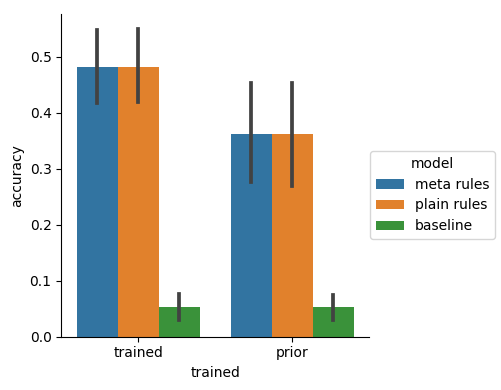

PyObject <seaborn.axisgrid.FacetGrid object at 0x1872fffd0>

In [72]:
mean(precisions_by_sequence)

LoadError: [91mUndefVarError: precisions_by_sequence not defined[39m

In [34]:
@time correct_cons_by_sequence = pmap(gold_leafss, gold_trees) do ls, t
    num_common_cons(convert(Tree, best_tree(run_chartparser(ls, grammar))), t)
end
sum(correct_cons_by_sequence) / sum(num_cons(t) for t in gold_trees)

 23.940756 seconds (4.91 M allocations: 133.285 MiB, 0.95% gc time)


0.38235294117647056

## Prior accuracy

In [35]:
prior_grammar = init_jazz_grammar(identity);

In [36]:
@time prior_precisions = pmap(gold_leafss, gold_trees) do ls, t
    precision(convert(Tree, best_tree(run_chartparser(ls, prior_grammar))), t)
end

 22.608607 seconds (575.49 k allocations: 16.170 MiB)


10-element Array{Float64,1}:
 0.0689655
 0.615385 
 0.230769 
 0.290323 
 0.431034 
 0.309091 
 0.353846 
 0.444444 
 0.387755 
 0.490566 

In [37]:
mean(prior_precisions)

0.36221790739571796

## Baseline

In [57]:
right_baseline_grammar = begin
    implication = CFRule(['S']) do c
        ['S', 'A']
    end
    stop = CFRule(['S']) do c
        ['A']
    end
    termination = CFRule(['A']) do c
        ['a']
    end
    CFGrammar([implication, stop], [termination], ['S'])
end

right_branching_baseline_precisions = map(gold_trees, gold_leafss) do t, ls
    precision(convert(Tree, best_tree(run_chartparser(fill('a', length(ls)), right_baseline_grammar))), t)
end

mean(right_branching_baseline_precisions)

0.07892185194716608

In [58]:
left_baseline_grammar = begin
    implication = CFRule(['S']) do c
        ['A', 'S']
    end
    stop = CFRule(['S']) do c
        ['A']
    end
    termination = CFRule(['A']) do c
        ['a']
    end
    CFGrammar([implication, stop], [termination], ['S'])
end

left_branching_baseline_precisions = map(gold_trees, gold_leafss) do t, ls
    precision(convert(Tree, best_tree(run_chartparser(fill('a', length(ls)), left_baseline_grammar))), t)
end

mean(left_branching_baseline_precisions)

0.0748707268373924

## Circular parsing

In [ ]:
tic()
toq()
println()
chords = terminals(iReal_songs[4, :chords])
run_chartparser(chords[1:5], grammar, cyclic=false)
run_chartparser(chords[1:5], grammar, cyclic=true)

linear_times = [
    begin
        tic()
        run_chartparser(chords[1:i], grammar, cyclic=false)
        toq()
    end
    for i in 1:30
]

cyclic_times = [
    begin
        tic()
        run_chartparser(chords[1:i], grammar, cyclic=true)
        toq()
    end
    for i in 1:30
]

In [ ]:
Plots.plot([linear_times, cyclic_times])

In [ ]:
p = Plots.plot(
    linear_times, cyclic_times, 
    xlabel = "linear parsing time in sec", 
    ylabel = "cyclic parsing time in sec", 
    label  = "parsing", 
    legend = :bottomright,
    title  = "Linear relationship between cyclic and linear parsing times")
Plots.plot!(p, x->3x+1.2, label="x --> 3x+1.2")

In [ ]:
cyclic_runtime(n) = (cyclic_times[end] / 30^3) * n^3
linear_runtime(n) = (linear_times[end] / 30^3) * n^3

In [ ]:
cyclic_runtime(60), linear_runtime(60)

## Filter sequences that have m6 chords

In [ ]:
# names of columns
print.(names(iReal_songs), '\t');

In [ ]:
# all chord forms in the corpus
print.(unique(vcat(getindex.(iReal_songs[:chords], [:chordform])...)), '\t');

In [ ]:
iReal_songs[:m6] = map(getindex.(iReal_songs[:chords], [:chordform])) do forms
    "m6" in forms
end

# number of songs that contain m6 chords
sum(iReal_songs[:m6]), size(iReal_songs, 1)

In [ ]:
# plot histogram of chord sequencs lengths
sequence_lengths = size.(iReal_songs[:chords], 1)
Plots.histogram(sequence_lengths)

In [ ]:
Plots.histogram(sequence_lengths, xlim=(0, 150), xticks=0:10:150)

In [ ]:
count(n->n<=60, sequence_lengths), count(n->n<=60, sequence_lengths) / length(sequence_lengths)

$\sim 75\%$ of the sequences (877) consist of 60 or less chords.

In [ ]:
# expected time for parsing all sequences of length 30 or shorter in minutes
sum(cyclic_runtime.(filter(n->n<=30, sequence_lengths))) / 60

In [ ]:
# expected time for parsing all sequences of length 30 or shorter in hours
sum(cyclic_runtime.(filter(n->n<=60, sequence_lengths))) / 60 / 60

## Print beginning and end of iReal sequences

In [ ]:
k = 3
for i in 10*k+1:10*(k+1)
    println(i, '\t', iReal_songs[i, :key], '\t', iReal_songs[i, :title])
    println(terminals(iReal_songs[i, :chords])[1:10])
    println(terminals(iReal_songs[i, :chords])[end-9:end])
    println()
end

## Write csv files for tree annotation

In [ ]:
# write csv files for tree annotation
# 
# cd("/Users/daniel/Documents/GitHub/iRealPro/iReal_csv/")
# for (file, chords_df) in zip(iReal_songs[:file], iReal_songs[:chords])
#     open(splitext(file)[1]*".csv", "w") do f
#         print(f, chords_df[:bar][1])
#         for b in Iterators.drop(chords_df[:bar], 1)
#             print(f, ';', b)
#         end
#         print(f, '\n')
#         print(f, chords_df[:beat][1])
#         for b in Iterators.drop(chords_df[:beat], 1)
#             print(f, ';', b)
#         end
#         print(f, '\n')
#         print(f, terminals(chords_df)[1])
#         for t in Iterators.drop(terminals(chords_df), 1)
#             print(f, ';', t)
#         end
#     end
# end